In [148]:
# Import Dependencies
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import scipy.stats as stats

# Data Import
Keeping necessary columns only to limit memory usage and impove performance

In [149]:
customer_shopping_data_csv = Path("./Resources/output/customer_shopping_data.csv")

customer_shopping_data_df = pd.read_csv(customer_shopping_data_csv)

#Keep only the columns that are actually used in the analysis. This practice allows for optimization of memory usage and improvement of performance.


customer_shopping_data_df = customer_shopping_data_df[['Invoice Date', 'Gender', 'Age', 'Age Group', 'Age Range', 'Category', 'Quantity', 
                                                       'Price (USD)', 'Cost (USD)', 'Cost Group', 'Payment Method', 'Shopping Mall', 
                                                       'Temp (F)', 'Humidity (%)', 'Precip (in)', 'Precip Type', 'Snowfall (in)', 'Snow Depth (in)', 
                                                       'Wind Speed (mph)', 'Clouds (%)', 'Conditions', 'Month', 'Day Of Year', 'Date Of Year', 'Year']]

customer_shopping_data_df.head()

,Invoice Date,Gender,Age,Age Group,Age Range,Category,Quantity,Price (USD),Cost (USD),Cost Group,...,Precip Type,Snowfall (in),Snow Depth (in),Wind Speed (mph),Clouds (%),Conditions,Month,Day Of Year,Date Of Year,Year
0,2022-08-05,Female,28,Adult,"(18.0, 28.0]",Clothing,4,899.219544,3596.878175,Upper,...,NaN,0.0,0.0,16.4,36.7,Partially cloudy,8,217,8/5,2022
1,2022-08-22,Female,43,Adult,"(38.0, 49.0]",Technology,2,27.083484,54.166969,Lower,...,NaN,0.0,0.0,14.9,49.6,Partially cloudy,8,234,8/22,2022
2,2022-08-25,Male,22,Adult,"(18.0, 28.0]",Food & Beverage,16,20.409061,326.544968,Middle,...,rain,0.0,0.0,6.8,74.7,"Rain, Partially cloudy",8,237,8/25,2022
3,2022-08-21,Male,21,Adult,"(18.0, 28.0]",Clothing,2,8.462653,16.925307,Lower,...,NaN,0.0,0.0,15.1,48.1,Partially cloudy,8,233,8/21,2022
4,2022-08-04,Male,39,Adult,"(38.0, 49.0]",Cosmetics,1,4.939042,4.939042,Lower,...,NaN,0.0,0.0,17.9,39.6,Partially cloudy,8,216,8/4,2022


## Defining generic analytical functions

In [150]:
def metrics_distribution_by_attribute(df, attribute_name, title_ext="", fig_height = 9):
    #Define a list of metrics for analysis and their corresponding colors.

    metrics = ["Price (USD)", "Cost (USD)", "Quantity"]
    colors = ["blue", "red", "green"]
   
    #Conduct an ANOVA test because it is versatile and allows comparing any number of groups with each other.
    #Iterate through all metrics.

    for metric in metrics:
        buckets = [] 

        for bucket, group in df.groupby(attribute_name):
            buckets.append(group[metric])

        statistic, pvalue = stats.f_oneway(*buckets)

        #Display the test results and conclusion, calculated based on the p-value.

        print("ANOVA test results:")
        print(f"Statistic = {statistic}, p-value = {pvalue}")
        if pvalue < 0.05:
            print(f"H0 should be rejected, indicating that there are statistically significant differences in the distribution of {metric} by {attribute_name}.")
        else:
            print(f"H0 should be accepted, indicating that there are no statistically significant differences in the distribution of {metric} by {attribute_name}.")
    
    #Start creating a set of charts. Determine the size of the plotting area.

    fig = plt.figure(figsize=(12, fig_height))

    #Iterate through all metrics.

    i = 1
    for metric in metrics:
       
        #Find the color in the colors list that corresponds to the metric.
        color = colors[metrics.index(metric)]

        #Construct a bar chart that shows the aggregated average value of price/cost/quantity.
        #For its construction, grouping of the original DataFrame is performed on the fly, without saving the result of grouping in a new DataFrame.

        ax1 = fig.add_subplot(3, 2, i)
        df.groupby(attribute_name).agg({metric: "mean"}).plot(kind="bar", color=color, alpha=0.75, ax=ax1)
        
        #Increment the variable value to move to the next chart.
        i = i + 1

        #Construct a boxplot that shows the distribution of price/cost/quantity values.
        ax2 = fig.add_subplot(3, 2, i)
        df.boxplot(column=metric, by=attribute_name, ax=ax2)
        plt.xticks(rotation=90)
        #Increment the variable value to move to the next chart.
        i = i + 1

    fig.suptitle(f"Distribution Price (USD), Cost (USD) and Quantity by {attribute_name} {title_ext}")
    plt.tight_layout() 
    plt.show()

In [151]:
def comparison_w_equal_distribution(observed, title = ""):
    #calculated expected as an average of all observed values
    expected = [[sum(observed) / len(observed)] * len(observed)]

    #perform Chi-square test
    statistic, pvalue = stats.chisquare(f_obs=observed, f_exp=expected[0])

    #Display the test results and conclusion, calculated based on the p-value.
    print("Chi-square test results:")
    print(f"Statistic = {statistic}, p-value = {pvalue}")
    if pvalue < 0.05:
        print(f"H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.\n")
    else:
        print(f"H0 should be accepted, indicating that there are no statistically significant differences in the observed distribution comparing to the equal distribution.\n")

    #draw a chart with observed (bar) and expected (line) values
    observed.plot(kind="bar")
    #draw an average line
    plt.plot(observed.index, expected[0], linestyle='-', color="red")
    plt.title(title)
    plt.show()

In [152]:
def comparison_w_equal_distribution_for_all_metrics(df, attribute_name, title_ext = "", fig_height = 6.5):
    #Define a list of metrics for analysis and their corresponding colors.
    metrics = ["Price (USD)", "Cost (USD)", "Quantity"]
    colors = ["blue", "red", "green"]

    #define lists to save aggregated values in order to not calculate them twice. It should impove performance
    observed_list = []
    excepted_list = []

    for metric in metrics:
        observed = df[metric]
        observed_list.append(observed)

        #calculated expected as an average of all observed values
        expected = [[sum(observed) / len(observed)] * len(observed)]
        excepted_list.append(expected[0])

        #perform Chi-square test
        statistic, pvalue = stats.chisquare(f_obs=observed, f_exp=expected[0])

        #Display the test results and conclusion, calculated based on the p-value.
        print("Chi-square test results:")
        print(f"Statistic = {statistic}, p-value = {pvalue}")
        if pvalue < 0.05:
            print(f"H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of {metric} comparing to the equal distribution.\n")
        else:
            print(f"H0 should be accepted, indicating that there are no statistically significant differences in the observed distribution of {metric} comparing to the equal distribution.\n")

    fig = plt.figure(figsize=(15, fig_height))

    i = 1
    for metric in metrics:
        #Find the color in the colors list that corresponds to the metric.
        color = colors[metrics.index(metric)]

        ax1 = fig.add_subplot(1, 3, i)

        #extract observed and expected from the appropriate lists
        observed = observed_list[metrics.index(metric)]
        expected = excepted_list[metrics.index(metric)]

        #draw a chart with observed (bar) and expected (line) values
        observed.plot(kind="bar", color=color, alpha=0.75, ax=ax1)

        ax1.plot(observed.index-1, expected, linestyle='-', color="black")
        ax1.set_title(f"Distribution of {metric} by {attribute_name}")

        #Increment the variable value to move to the next chart.
        i = i + 1

    fig.suptitle(f"Distribution of Average Price (USD), Total Cost (USD) and Total Quantity by {attribute_name} {title_ext}")
    plt.tight_layout() 
    plt.show()

In [153]:
def time_series_plots(df):
    df = df.groupby(["Day Of Year", "Date Of Year"]).agg({"Price (USD)": "mean", "Cost (USD)": "sum", "Quantity": "sum"})

    df.reset_index(inplace=True)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_size_inches(20, 9.5)

    ax1.plot(df["Day Of Year"], df["Price (USD)"], color="blue")
    ax1.set_ylabel("Price (USD)")
    ax1.set_ylabel("Average Price (USD)")
    ax1.set_xticks(df["Day Of Year"][::5])
    ax1.set_xticklabels(df["Date Of Year"][::5], rotation=90)

    (p_slope, p_int, p_r, _, _) = stats.linregress(df["Day Of Year"], df["Price (USD)"])
    p_fit = p_slope * df["Day Of Year"] + p_int
    ax1.plot(df["Day Of Year"], p_fit, linestyle='--', color="black")
    print(f"Correlation between Price (USD) and Day Of Year is {p_r}")

    ax2.plot(df["Day Of Year"], df["Cost (USD)"], color="red")
    ax2.set_ylabel("Price (USD)")
    ax2.set_ylabel("Total Cost (USD)")
    ax2.set_xticks(df["Day Of Year"][::5])
    ax2.set_xticklabels(df["Date Of Year"][::5], rotation=90)

    (c_slope, c_int, c_r, _, _) = stats.linregress(df["Day Of Year"], df["Cost (USD)"])
    c_fit = c_slope * df["Day Of Year"] + c_int
    ax2.plot(df["Day Of Year"], c_fit, linestyle='--', color="black")
    print(f"Correlation between Cost (USD) and Day Of Year is {c_r}")

    ax3.plot(df["Day Of Year"], df["Quantity"], color="green")
    ax3.set_ylabel("Quantity")
    ax3.set_ylabel("Total Quantity")
    ax3.set_xticks(df["Day Of Year"][::5])
    ax3.set_xticklabels(df["Date Of Year"][::5], rotation=90)

    (q_slope, q_int, q_r, _, _) = stats.linregress(df["Day Of Year"], df["Quantity"])
    q_fit = q_slope * df["Day Of Year"] + q_int
    ax3.plot(df["Day Of Year"], q_fit, linestyle='--', color="black")
    print(f"Correlation between Quantity and Day Of Year is {q_r}")

    plt.show()

# Common analytics
Analytics against the whole data set

## Preferable payment methods in Lower and Upper Price bins

Chi-square test results:
Statistic = 6453.664432825905, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



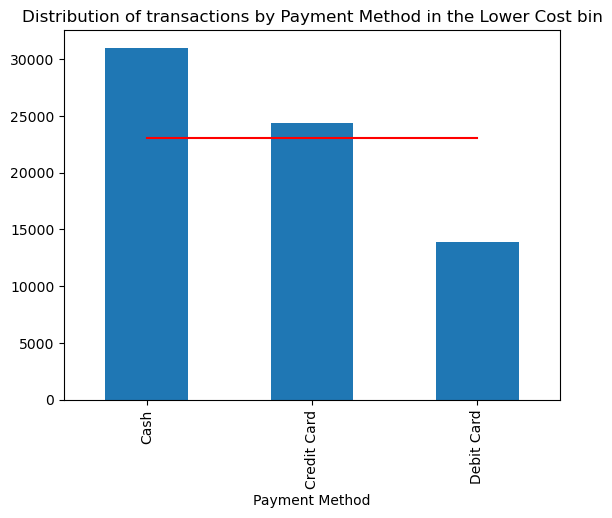

In [154]:
#Comparing the observed distribution of transaction counts by filtering by bucket number and grouping by payment method with an equal (average) distribution for Lower bin
#Within each group, count the number of entries = number of transactions
lower_bin_observed = customer_shopping_data_df[(customer_shopping_data_df["Cost Group"] == "Lower")].groupby("Payment Method").size()

comparison_w_equal_distribution(lower_bin_observed, "Distribution of transactions by Payment Method in the Lower Cost bin")

*Red line* is the equal distribution

`pvalue` = 0, we should reject H0; therefore, the difference in the payment methods for number of transactions in the Lower Cost bin is not random

**Cash** is the most preferrable method, while **Debit Card** is the least popular payment method

ANOVA test results:
Statistic = 2.9900057706566274, p-value = 0.050293640027127794
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Price (USD) by Payment Method.
ANOVA test results:
Statistic = 3.387747794858947, p-value = 0.03379028177552205
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Cost (USD) by Payment Method.
ANOVA test results:
Statistic = 1.047841729136924, p-value = 0.35069938663495426
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Quantity by Payment Method.


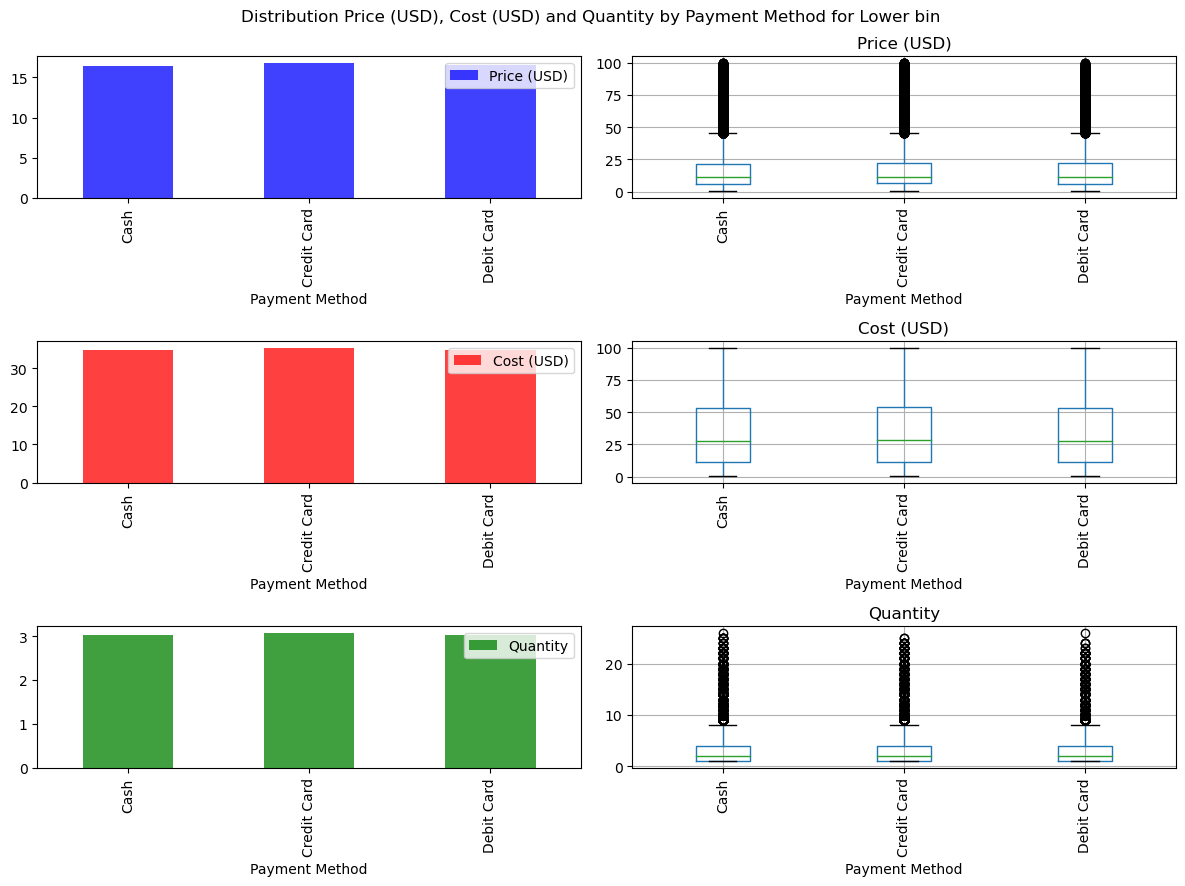

In [155]:
#ANOVA test for Price/Cost/Quantity distribution for each transaction by Payment Method for Lower bin
df = customer_shopping_data_df[(customer_shopping_data_df["Cost Group"] == "Lower")]

metrics_distribution_by_attribute(df, attribute_name="Payment Method", title_ext="for Lower bin")

`pvalue` > 0.05 in for price and quanity, but not for cost; therefore, the difference in the payment methods for an average transaction in the **Lower Cost** bin is random for average price, average quantity of the transaction; however, for average cost the dependency exists, i.e. for transactions with higher cost there is higher probability to use **Credit Card** payment method

Chi-square test results:
Statistic = 275.09324566646745, p-value = 1.8376411149522586e-60
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



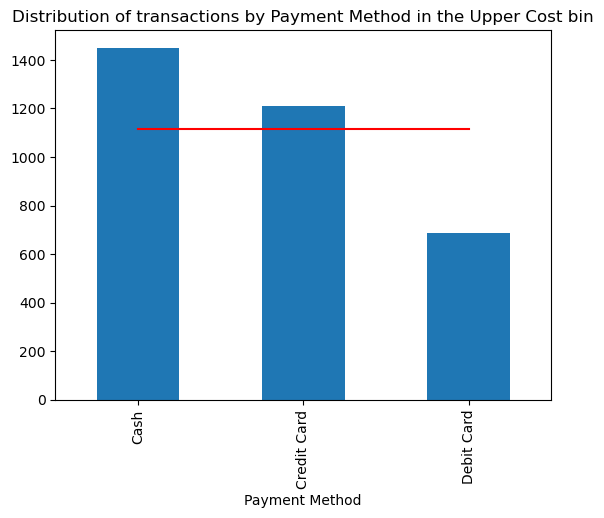

In [156]:
#Comparing the observed distribution of transaction counts by filtering by bucket number and grouping by payment method with an equal (average) distribution for Upper bin
#Within each group, count the number of entries = number of transactions
upper_bin_observed = customer_shopping_data_df[(customer_shopping_data_df["Cost Group"] == "Upper")].groupby("Payment Method").size()

comparison_w_equal_distribution(upper_bin_observed, "Distribution of transactions by Payment Method in the Upper Cost bin")

*Red line* is the equal distribution

`pvalue` = 0, we should reject H0; therefore, the difference in the payment methods for number of transactions in the Lower Price bin is not random

**Cash** is the most preferrable method, **Credit Card** is slightly less preferrable, while **Debit Card** is the least popular payment method

The picture is similar to the Lower Price bin, but **Credit Card** payment method is more popular

ANOVA test results:
Statistic = 0.3103487306787472, p-value = 0.7332123472791863
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Price (USD) by Payment Method.
ANOVA test results:
Statistic = 0.7370501640361774, p-value = 0.4786011454557041
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Cost (USD) by Payment Method.
ANOVA test results:
Statistic = 0.6535438412998831, p-value = 0.5202654539745308
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Quantity by Payment Method.


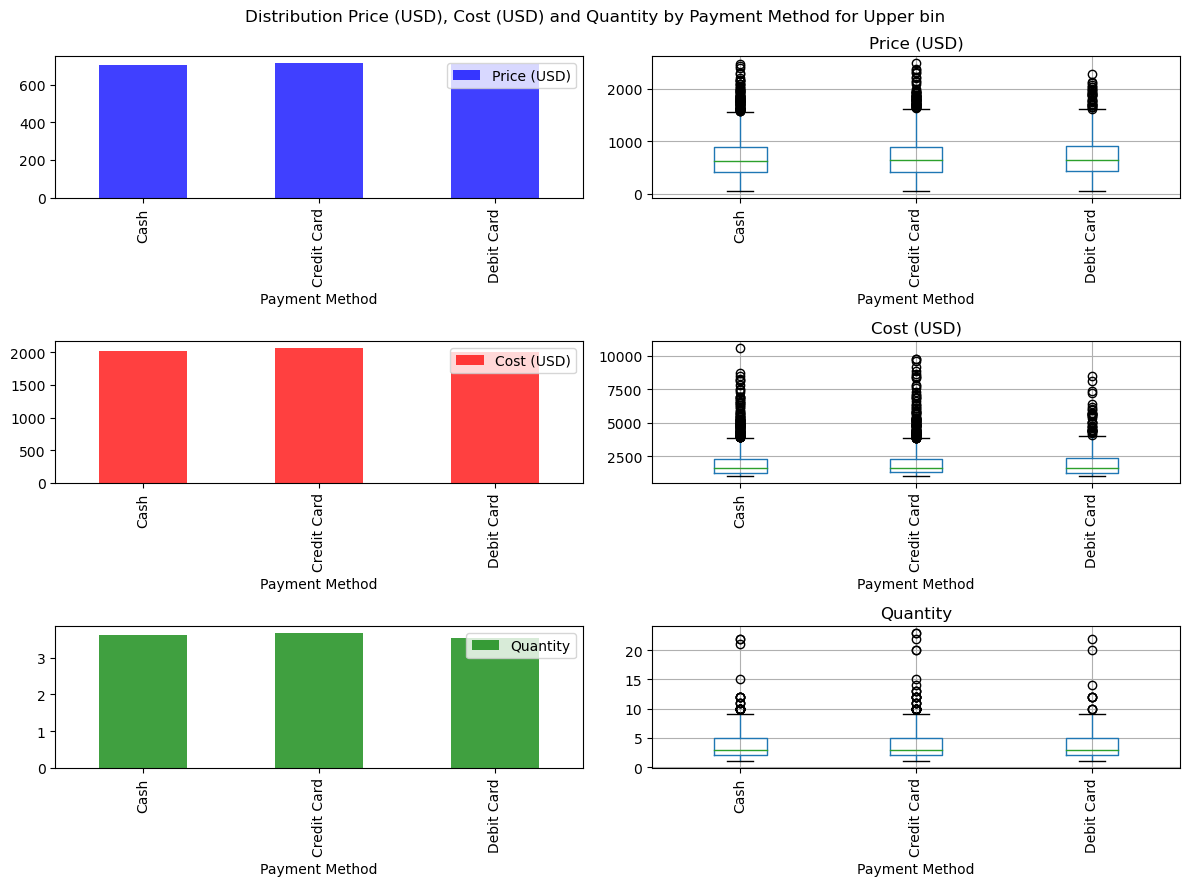

In [157]:
#ANOVA test for Price/Quantity distribution for each transaction by Payment Method for Upper bin
df = customer_shopping_data_df[(customer_shopping_data_df["Cost Group"] == "Upper")]

metrics_distribution_by_attribute(df, attribute_name="Payment Method", title_ext="for Upper bin")

`pvalue` > 0.05 in all cases; we cannot reject H0; therefore, the difference in the payment methods for an average transaction in the **Upper Price** bin is random for average price, average cost and average quantity of the transaction

### Test the hypothesis that the price/cost/quantity of products purchased in a single transaction within a certain category depends on the age of the buyers

ANOVA test results:
Statistic = 1.546745583431093, p-value = 0.18562184500305656
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Price (USD) by Age Range.
ANOVA test results:
Statistic = 1.1492081971387265, p-value = 0.33122644544194785
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Cost (USD) by Age Range.
ANOVA test results:
Statistic = 0.9191450015919479, p-value = 0.4515459189172851
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Quantity by Age Range.


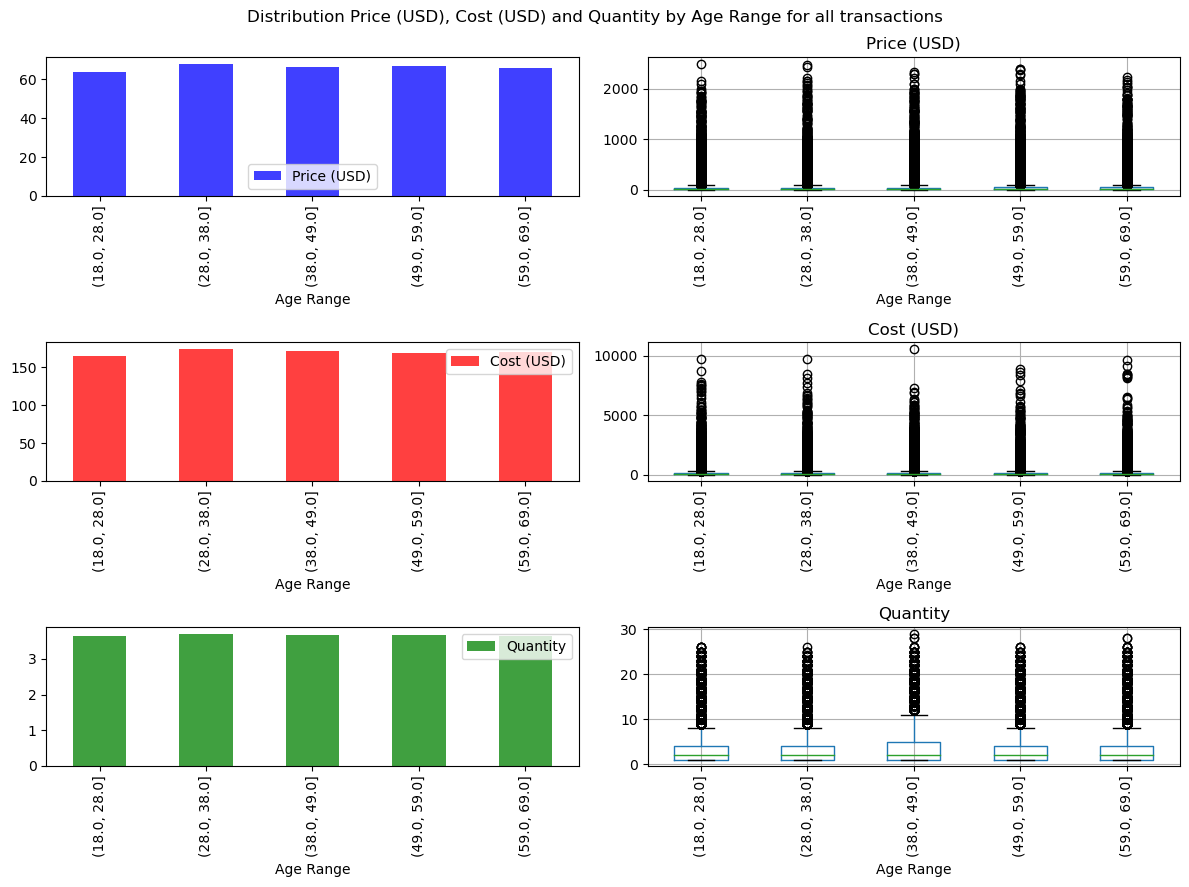

In [158]:
#check all transactions
metrics_distribution_by_attribute(customer_shopping_data_df, attribute_name="Age Range", title_ext="for all transactions")

`pvalue` > 0.05 in all cases. We cannot reject H0; therefore, the difference in both average price, average cost and average of all transaction by age bins is random

ANOVA test results:
Statistic = 3.870588514368944, p-value = 0.0038036568636040553
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Price (USD) by Age Range.
ANOVA test results:
Statistic = 2.6867405983136856, p-value = 0.029576921553371868
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Cost (USD) by Age Range.
ANOVA test results:
Statistic = 1.3558177665379898, p-value = 0.24658103843683532
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Quantity by Age Range.


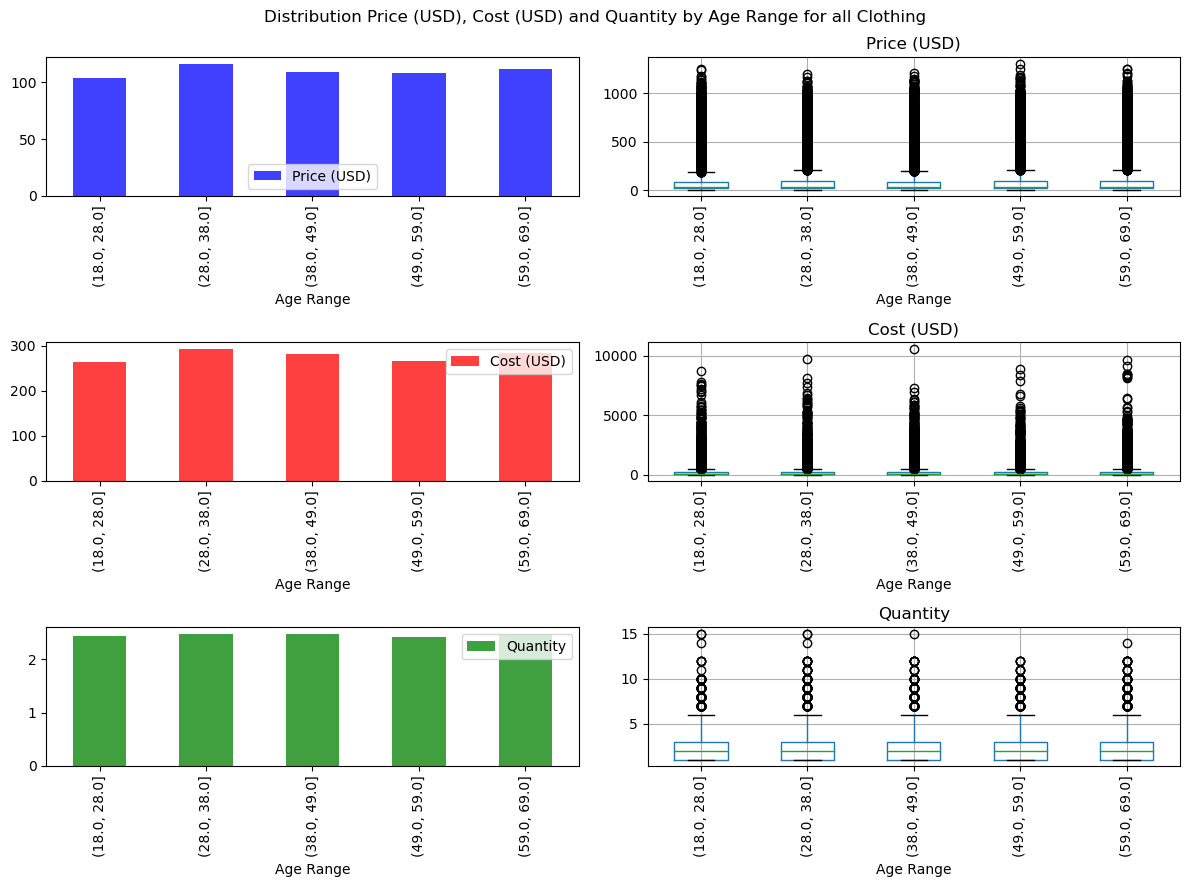

In [159]:
#Check Clothing category
df = customer_shopping_data_df[(customer_shopping_data_df["Category"] == "Clothing")]

metrics_distribution_by_attribute(df, attribute_name="Age Range", title_ext="for all Clothing")

`pvalue` < 0.05 for price and cost, but not for quantity. Therefore, we can consider that people of age **28-38** prefer more *expensive* goods in the Clothing category, while in average people in all age bins purchase the similar quantity.

### Test the hypothesis that the price/cost/quantity of products purchased in a single transaction within a certain category depends on the gender of customers

ANOVA test results:
Statistic = 589.9848874742073, p-value = 3.0863680323931976e-129
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Price (USD) by Gender.
ANOVA test results:
Statistic = 1071.2032332519773, p-value = 2.1088599375335468e-231
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Cost (USD) by Gender.
ANOVA test results:
Statistic = 3057.6922025226527, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Quantity by Gender.


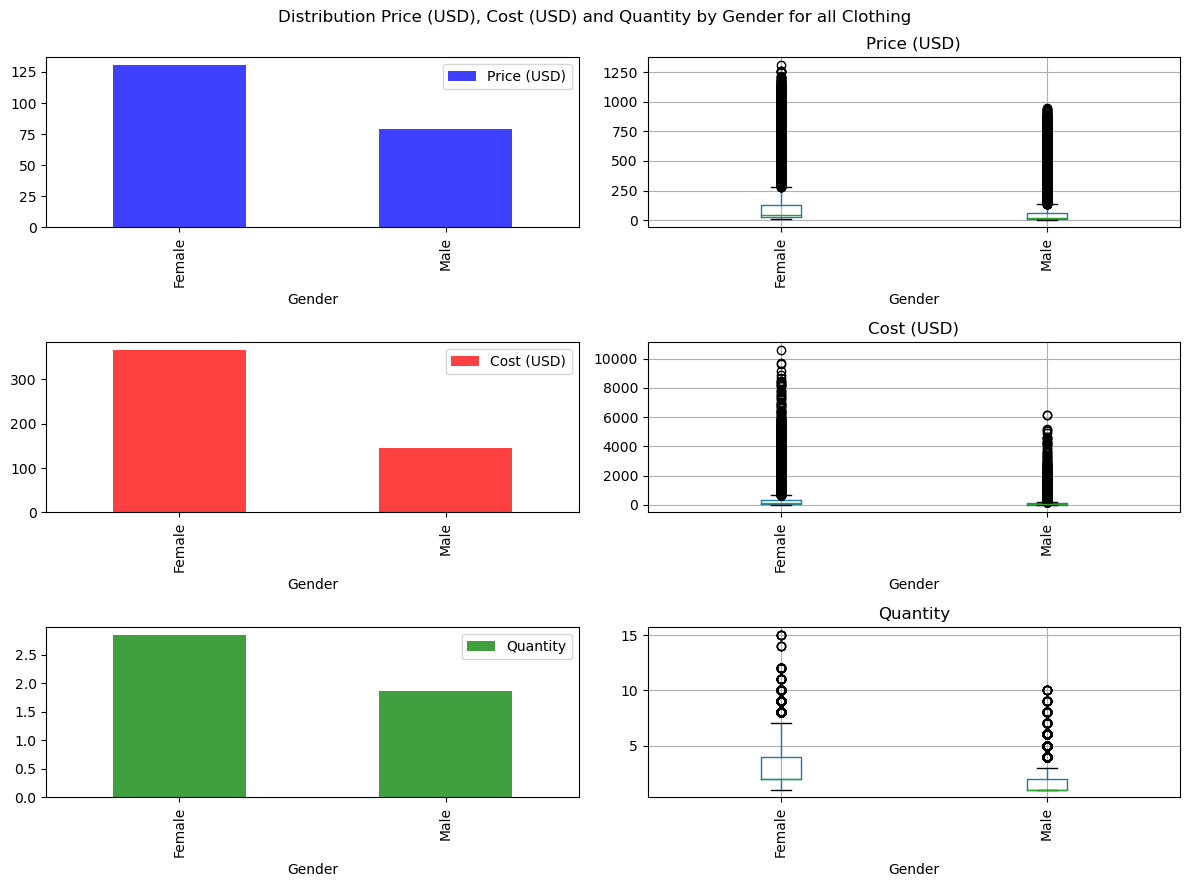

In [160]:
#Distribution of average Price, Cost and Quantity for Clothing transactions by gender
df = customer_shopping_data_df[(customer_shopping_data_df["Category"] == "Clothing")]

metrics_distribution_by_attribute(df, attribute_name="Gender", title_ext="for all Clothing")

`pvalue` < 0.05 for all metrics. Therefore, we can consider than **Women** prefer more expensive goods and purchase more items in the **Clothing** category.

ANOVA test results:
Statistic = 940.9716898988199, p-value = 1.6373303531811026e-200
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Price (USD) by Gender.
ANOVA test results:
Statistic = 1613.6848183697573, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Cost (USD) by Gender.
ANOVA test results:
Statistic = 5480.716589764455, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Quantity by Gender.


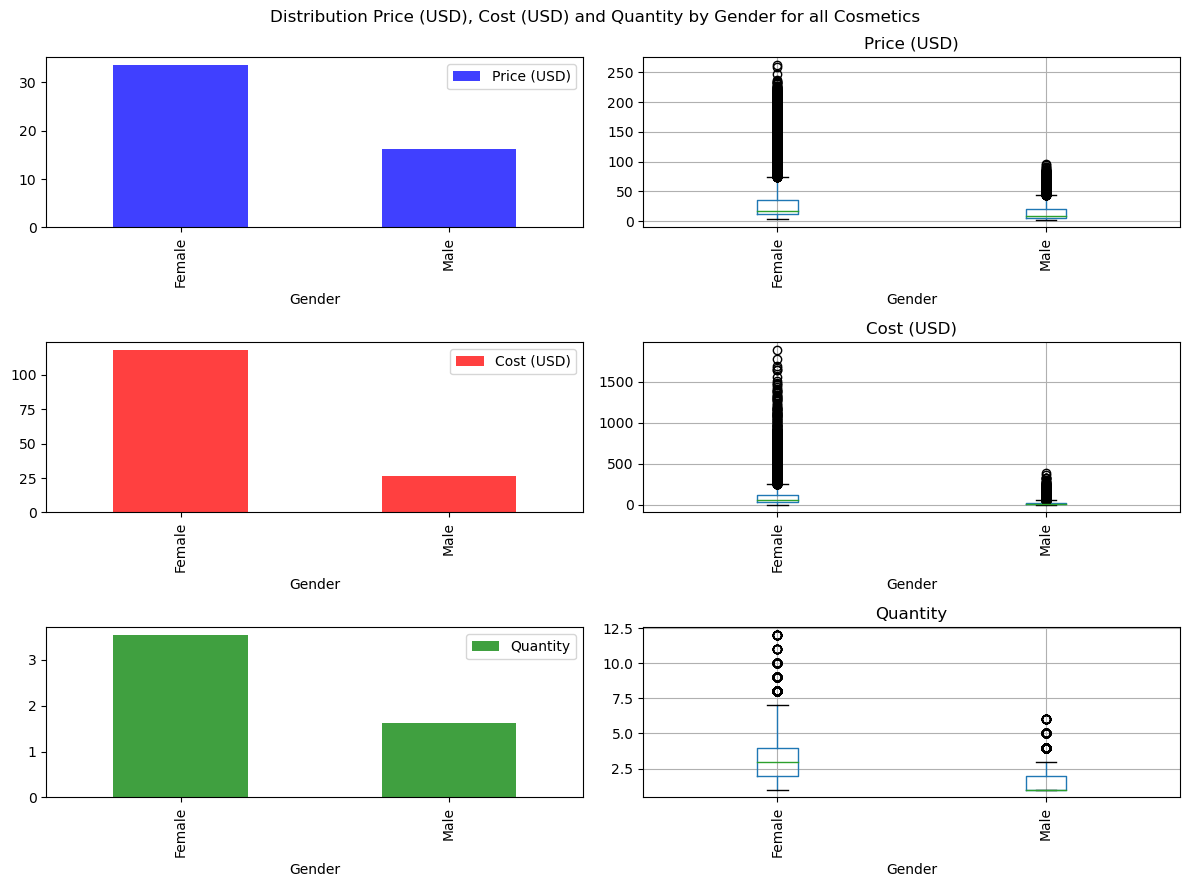

In [161]:
#Distribution of average Price, Cost and Quantity for Cosmetics transactions by gender
df = customer_shopping_data_df[(customer_shopping_data_df["Category"] == "Cosmetics")]

metrics_distribution_by_attribute(df, attribute_name="Gender", title_ext="for all Cosmetics")

`pvalue` < 0.05 for all metrics. Therefore, we can consider than **Women** prefer more expensive goods and purchase more items in the **Cosmetics** category.

ANOVA test results:
Statistic = 2.0034464315955036, p-value = 0.15700432728450237
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Price (USD) by Gender.
ANOVA test results:
Statistic = 367.56279899668266, p-value = 4.142561039727683e-79
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Cost (USD) by Gender.
ANOVA test results:
Statistic = 2026.7855392169695, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Quantity by Gender.


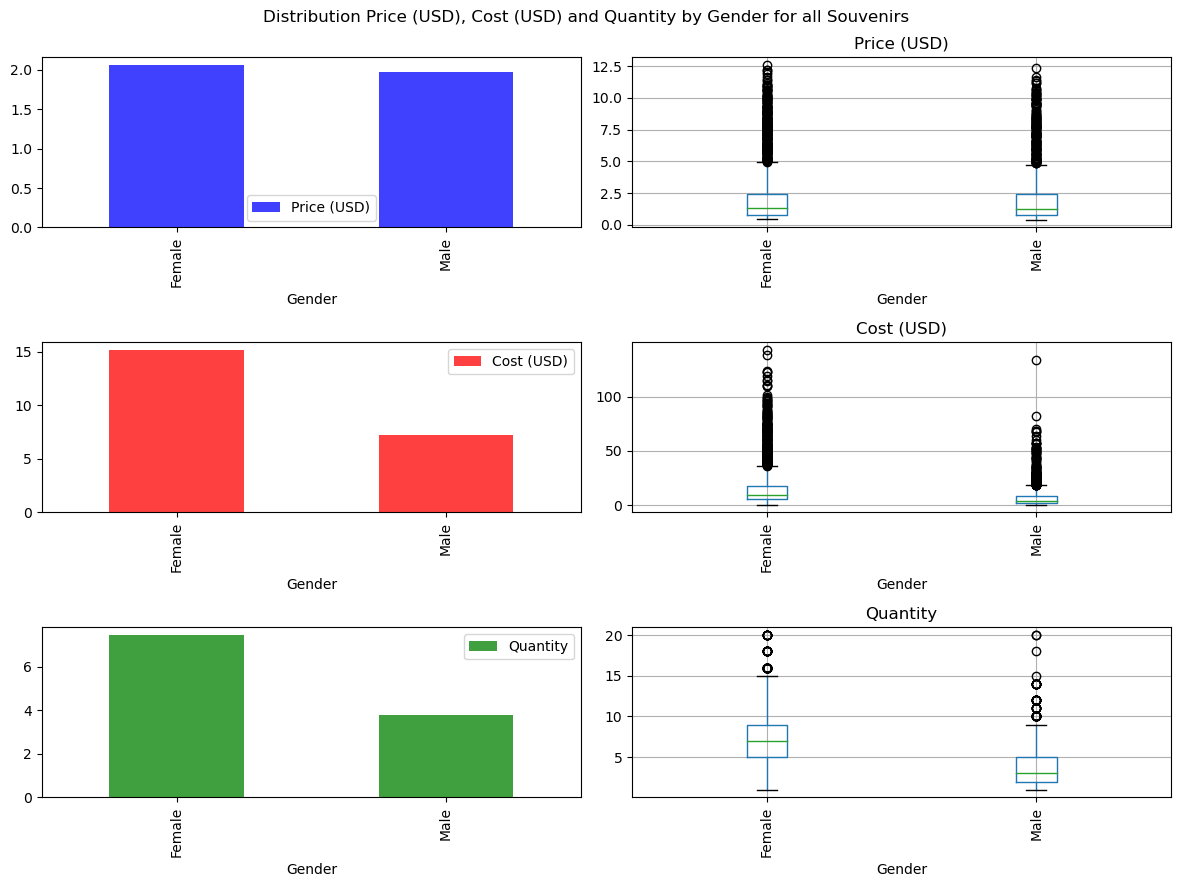

In [162]:
#Distribution of average Price, Cost and Quantity for Clothing transactions by Souvenir
df = customer_shopping_data_df[(customer_shopping_data_df["Category"] == "Souvenir")]

metrics_distribution_by_attribute(df, attribute_name="Gender", title_ext="for all Souvenirs")

`pvalue` < 0.05 for cost and quantity, but not for price. Therefore, we can consider that **Women** prefer to purchase more goods of the Souvenir category than **Men**, but of the same average price.

# Shopping malls traffic

### Checking the hypothesis are there shopping malls that are preferrable by females more than males and vise verca?

In [163]:
#Test the hypothesis that women or men prefer some malls over others.
#H0 - women (and men) visit all malls with equal frequency, not favoring any specific ones.
#Calculate the proportion of women and men in the entire dataset. This ratio is 60:40.

female_ratio = customer_shopping_data_df[(customer_shopping_data_df["Gender"] == "Female")]["Gender"].count() / len(customer_shopping_data_df)
male_ratio = customer_shopping_data_df[(customer_shopping_data_df["Gender"] == "Male")]["Gender"].count() / len(customer_shopping_data_df)

print(female_ratio)
print(male_ratio)

0.5980675065606242
0.4019324934393758


In [164]:
#Insert data for the chi-square test, which determines whether the deviations of actual values from expected ones are statistically significant.
#DataFrame needs to be created where each row corresponds to a mall and there are two columns - expected and actual visits.
#Obtain the distribution of the number of customers across all malls.
customers_by_malls = customer_shopping_data_df.groupby("Shopping Mall").size()
#Obtain the distribution of the actual number of female customers across all malls.
female_customers_by_mall_observed = customer_shopping_data_df[(customer_shopping_data_df["Gender"] == "Female")].groupby("Shopping Mall").size()
#Obtain the distribution of the actual number of male customers across all malls.
male_customers_by_mall_observed = customer_shopping_data_df[(customer_shopping_data_df["Gender"] == "Male")].groupby("Shopping Mall").size()
#Calculate the expected number of customers of both genders, using the formula total number of customers x the proportion of women (men) in the overall distribution.
female_customers_by_mall_expected = customers_by_malls * female_ratio
male_customers_by_mall_expected = customers_by_malls * male_ratio

print(customers_by_malls)
print(female_customers_by_mall_observed)
print(male_customers_by_mall_observed)
print(female_customers_by_mall_expected)
print(male_customers_by_mall_expected)

Shopping Mall
Cevahir AVM           4991
Emaar Square Mall     4811
Forum Istanbul        4947
Istinye Park          9781
Kanyon               19823
Mall of Istanbul     19943
Metrocity            15011
Metropol AVM         10161
Viaport Outlet        4914
Zorlu Center          5075
dtype: int64
Shopping Mall
Cevahir AVM           2940
Emaar Square Mall     2842
Forum Istanbul        3016
Istinye Park          5874
Kanyon               11906
Mall of Istanbul     11902
Metrocity             8941
Metropol AVM          6144
Viaport Outlet        2949
Zorlu Center          2968
dtype: int64
Shopping Mall
Cevahir AVM          2051
Emaar Square Mall    1969
Forum Istanbul       1931
Istinye Park         3907
Kanyon               7917
Mall of Istanbul     8041
Metrocity            6070
Metropol AVM         4017
Viaport Outlet       1965
Zorlu Center         2107
dtype: int64
Shopping Mall
Cevahir AVM           2984.954925
Emaar Square Mall     2877.302774
Forum Istanbul        2958.639955
Ist

In [165]:
female_customers_by_mall = pd.DataFrame({
    "observed": female_customers_by_mall_observed,
    "expected": female_customers_by_mall_expected
})

female_customers_by_mall

,observed,expected
Shopping Mall,,
Cevahir AVM,2940,2984.954925
Emaar Square Mall,2842,2877.302774
Forum Istanbul,3016,2958.639955
Istinye Park,5874,5849.698282
Kanyon,11906,11855.492183
Mall of Istanbul,11902,11927.260283
Metrocity,8941,8977.591341
Metropol AVM,6144,6076.963934
Viaport Outlet,2949,2938.903727


In [166]:
male_customers_by_mall = pd.DataFrame({
    "observed": male_customers_by_mall_observed,
    "expected": male_customers_by_mall_expected
})

male_customers_by_mall

,observed,expected
Shopping Mall,,
Cevahir AVM,2051,2006.045075
Emaar Square Mall,1969,1933.697226
Forum Istanbul,1931,1988.360045
Istinye Park,3907,3931.301718
Kanyon,7917,7967.507817
Mall of Istanbul,8041,8015.739717
Metrocity,6070,6033.408659
Metropol AVM,4017,4084.036066
Viaport Outlet,1965,1975.096273


16.918977604620448
Power_divergenceResult(statistic=5.002688625817329, pvalue=0.8340738229321143)


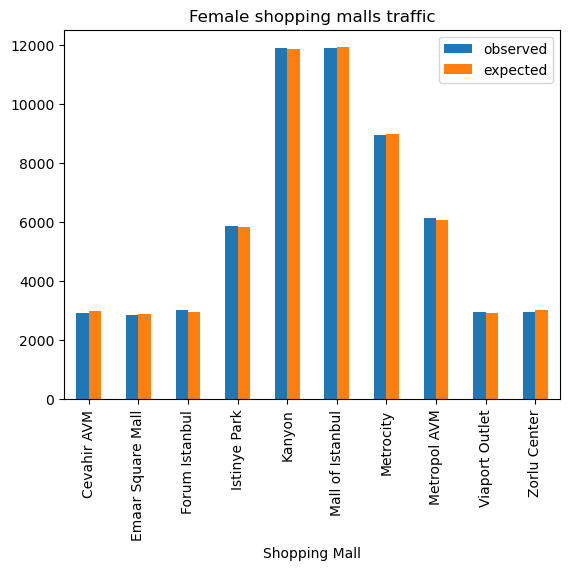

In [167]:
#Conduct a chi-square test for female visitation.
#Calculate the critical value (exceeding which we can consider the difference in visitation to be statistically significant).

degree_of_freedom = len(female_customers_by_mall) - 1
p_value = 0.05
confidence_level = 1- p_value

critical_value = stats.chi2.ppf(confidence_level, degree_of_freedom)
print(critical_value)

print(stats.chisquare(f_obs=female_customers_by_mall["observed"], f_exp=female_customers_by_mall["expected"]))

female_customers_by_mall.plot(kind="bar")
plt.title("Female shopping malls traffic")
plt.show()


`pvalue` =0.8340738229321143 > 0.05, we cannot reject H0; therefore, the difference in the visitation of various malls by women is random.


16.918977604620448
Power_divergenceResult(statistic=7.4439005588709115, pvalue=0.5910054758206086)


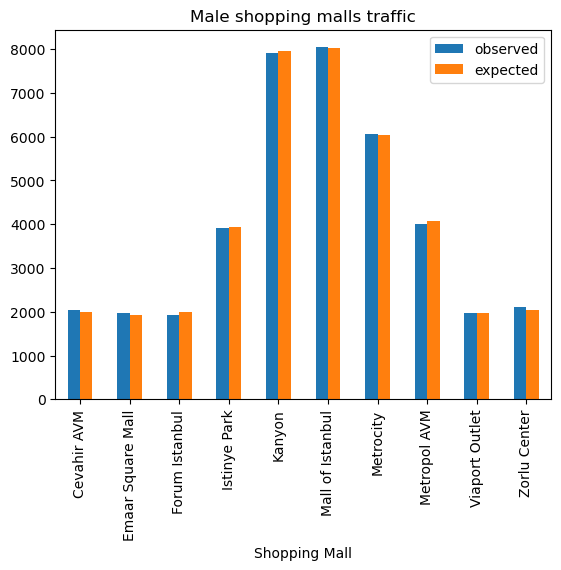

In [168]:
#Conduct a chi-square test for male visitation.
#Calculate the critical value (exceeding which we can consider the difference in visitation to be statistically significant).

degree_of_freedom = len(male_customers_by_mall) - 1
p_value = 0.05
confidence_level = 1- p_value

critical_value = stats.chi2.ppf(confidence_level, degree_of_freedom)
print(critical_value)

print(stats.chisquare(f_obs=male_customers_by_mall["observed"], f_exp=male_customers_by_mall["expected"]))

male_customers_by_mall.plot(kind="bar")
plt.title("Male shopping malls traffic")
plt.show()

`p-value` = 0.5910054758206086 > 0.05, thus we cannot reject H0; therefore, the difference in the visitation of various malls by men is random.


# Seasonal Variance Analysis
Analysis of dependency between sales activity and a month of a year

In [169]:
#Analyze the seasonal dependencies of customers,
#including the impact of weather conditions on purchasing activity.
#This analysis will enable the planning of marketing campaigns tailored to specific months or weather conditions.
#Data is isolated to complete years only before commencing the analysis.

full_years_df = customer_shopping_data_df[(customer_shopping_data_df["Year"].isin([2021, 2022]))]
full_years_df.head()

,Invoice Date,Gender,Age,Age Group,Age Range,Category,Quantity,Price (USD),Cost (USD),Cost Group,...,Precip Type,Snowfall (in),Snow Depth (in),Wind Speed (mph),Clouds (%),Conditions,Month,Day Of Year,Date Of Year,Year
0,2022-08-05,Female,28,Adult,"(18.0, 28.0]",Clothing,4,899.219544,3596.878175,Upper,...,NaN,0.0,0.0,16.4,36.7,Partially cloudy,8,217,8/5,2022
1,2022-08-22,Female,43,Adult,"(38.0, 49.0]",Technology,2,27.083484,54.166969,Lower,...,NaN,0.0,0.0,14.9,49.6,Partially cloudy,8,234,8/22,2022
2,2022-08-25,Male,22,Adult,"(18.0, 28.0]",Food & Beverage,16,20.409061,326.544968,Middle,...,rain,0.0,0.0,6.8,74.7,"Rain, Partially cloudy",8,237,8/25,2022
3,2022-08-21,Male,21,Adult,"(18.0, 28.0]",Clothing,2,8.462653,16.925307,Lower,...,NaN,0.0,0.0,15.1,48.1,Partially cloudy,8,233,8/21,2022
4,2022-08-04,Male,39,Adult,"(38.0, 49.0]",Cosmetics,1,4.939042,4.939042,Lower,...,NaN,0.0,0.0,17.9,39.6,Partially cloudy,8,216,8/4,2022


## Dependency On Weather Conditions Analysis

In [170]:
#Determine if there is a dependency in purchasing activity on weather conditions.
#For weather-related analysis, create a DataFrame grouped by days and product categories.
#For each group, calculate the number of transactions per day, total cost, average price, and total quantity.
#Use the max function for weather conditions to follow the syntax.

daily_df = full_years_df.groupby(["Invoice Date", "Category"]).agg({
    "Invoice Date": "count",
    "Cost (USD)": "sum",
    "Price (USD)": "mean",
    "Quantity": "sum",
    "Precip Type": "max",
    "Precip (in)": "max",
    "Conditions": "max"
})

#Add a new column "Have Snow," which has True/False values. True if the snow depth on a given day is > 0.
daily_df["Have Snow"] = full_years_df.groupby(["Invoice Date", "Category"])["Snow Depth (in)"].apply(lambda x: (x > 0).any())

#Rename the column to match its content. "Purchase Count" indicates the number of transactions on a specific day in a specific category.
daily_df.rename(columns={"Invoice Date": "Purchase Count"}, inplace=True)

#Replace empty (NaN) values with "none" for all columns and rows. 
daily_df.fillna("none", inplace=True)
daily_df.reset_index(inplace=True)
daily_df

,Invoice Date,Category,Purchase Count,Cost (USD),Price (USD),Quantity,Precip Type,Precip (in),Conditions,Have Snow
0,2021-01-01,Books,6,17.272018,2.878670,6,rain,0.154,"Rain, Partially cloudy",False
1,2021-01-01,Clothing,28,9986.958275,156.157632,56,rain,0.154,"Rain, Partially cloudy",False
2,2021-01-01,Cosmetics,19,1297.819658,28.422906,53,rain,0.154,"Rain, Partially cloudy",False
3,2021-01-01,Food & Beverage,14,2949.596731,19.711797,173,rain,0.154,"Rain, Partially cloudy",False
4,2021-01-01,Shoes,14,4043.497957,76.527718,50,rain,0.154,"Rain, Partially cloudy",False
...,...,...,...,...,...,...,...,...,...,...
5830,2022-12-31,Food & Beverage,14,1691.056845,12.682434,182,none,0.000,Clear,False
5831,2022-12-31,Shoes,10,956.877415,46.430980,27,none,0.000,Clear,False
5832,2022-12-31,Souvenir,9,63.715228,1.466176,35,none,0.000,Clear,False
5833,2022-12-31,Technology,7,1273.447752,179.507816,8,none,0.000,Clear,False


### Checking the hypothesis that purchases of shoes depend on weather conditions

ANOVA test results:
Statistic = 0.5890961372345661, p-value = 0.7651372513291305
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Price (USD) by Conditions.
ANOVA test results:
Statistic = 1.2437962492157204, p-value = 0.2761157158024714
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Cost (USD) by Conditions.
ANOVA test results:
Statistic = 3.265405451488516, p-value = 0.0020156877981812615
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Quantity by Conditions.


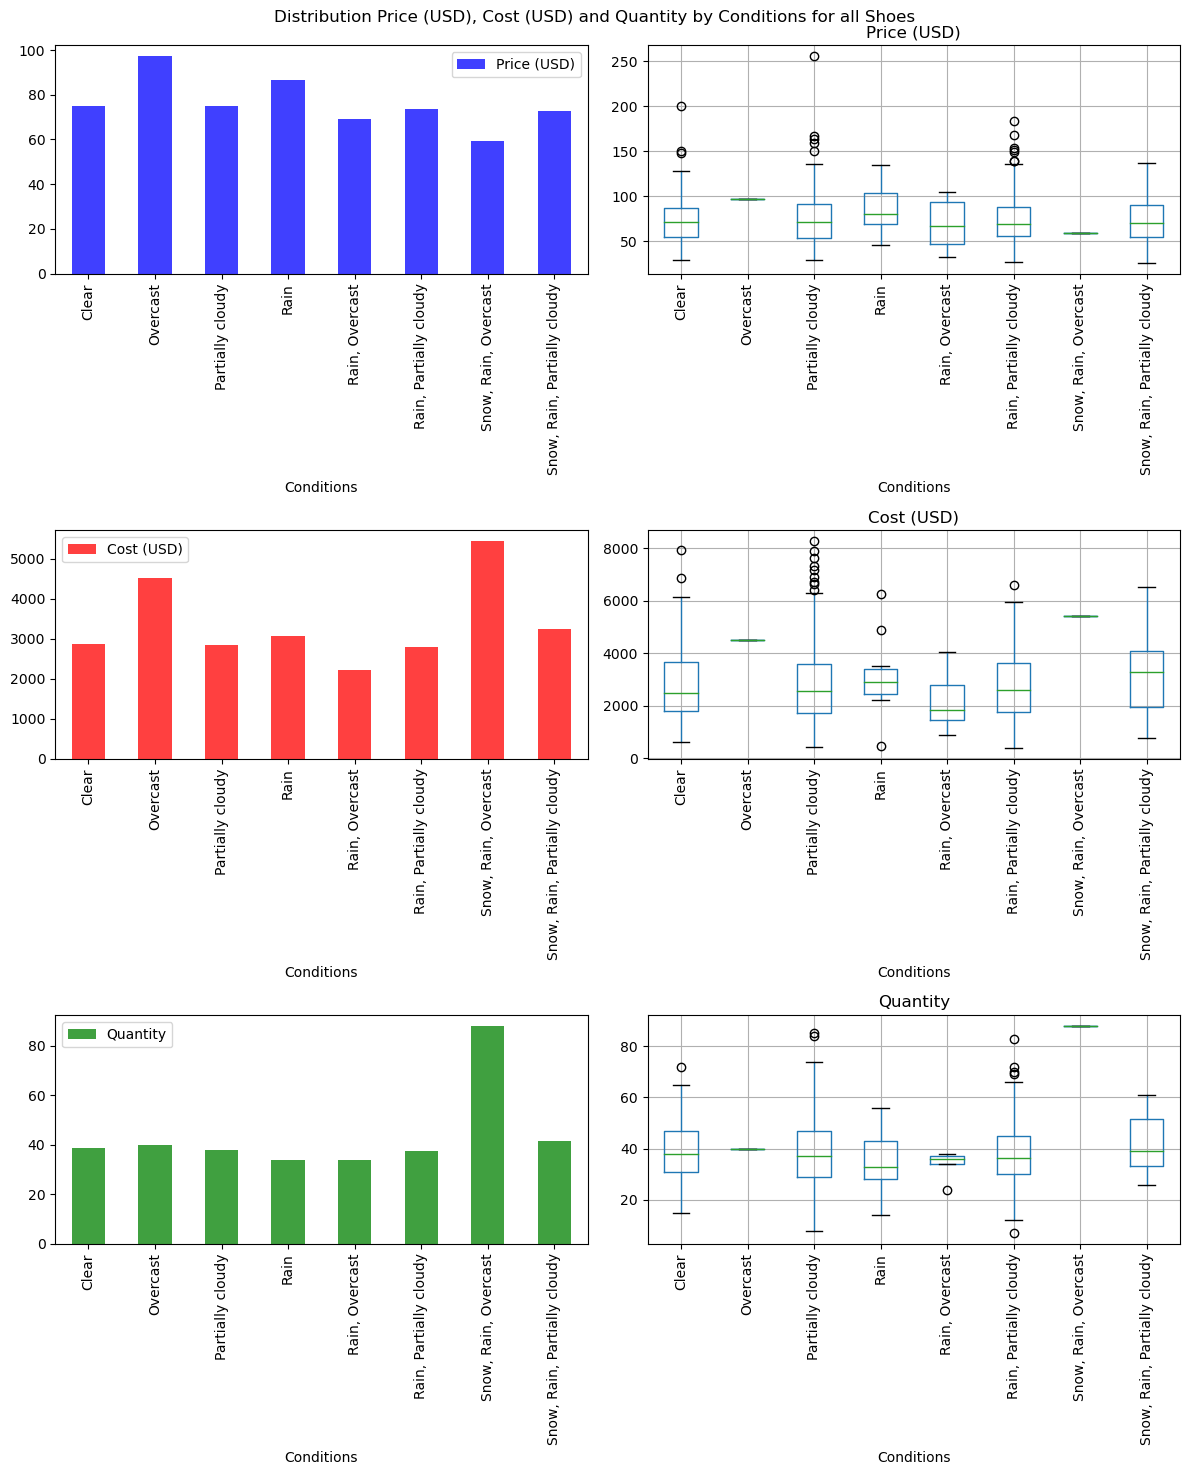

In [171]:
#Check Shoes category distributed by Weather conditions
df = daily_df[(daily_df["Category"] == "Shoes")]

metrics_distribution_by_attribute(df, attribute_name="Conditions", title_ext="for all Shoes", fig_height=15)

The most shoes are sold (average number of pairs of shoes per transaction) when there are "Snow, Rain, Overcast" conditions.

ANOVA test results:
Statistic = 0.1435177921563872, p-value = 0.8663299246536764
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Price (USD) by Precip Type.
ANOVA test results:
Statistic = 1.952921383161321, p-value = 0.14260253199584008
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Cost (USD) by Precip Type.
ANOVA test results:
Statistic = 3.363044873174952, p-value = 0.03516925603951183
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Quantity by Precip Type.


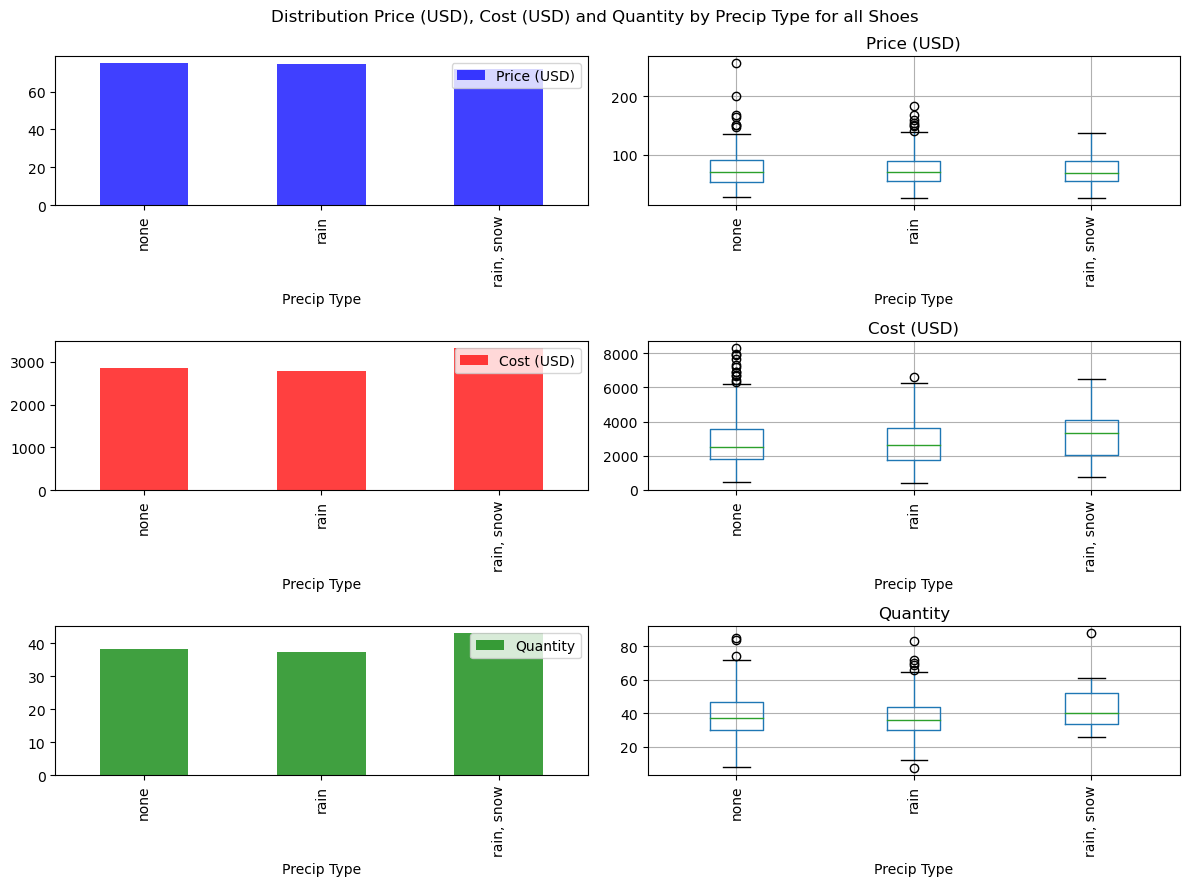

In [172]:
#Check Shoes category distributed by Precip Type
df = daily_df[(daily_df["Category"] == "Shoes")]

metrics_distribution_by_attribute(df, attribute_name="Precip Type", title_ext="for all Shoes")

The most shoes are sold (average number of pairs of shoes per transaction) when there are rain and snow conditions.

ANOVA test results:
Statistic = 0.7757847331455558, p-value = 0.37872410601528894
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Price (USD) by Have Snow.
ANOVA test results:
Statistic = 8.298485168815635, p-value = 0.004084450566608139
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Cost (USD) by Have Snow.
ANOVA test results:
Statistic = 2.9683693458752165, p-value = 0.08533205918804543
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Quantity by Have Snow.


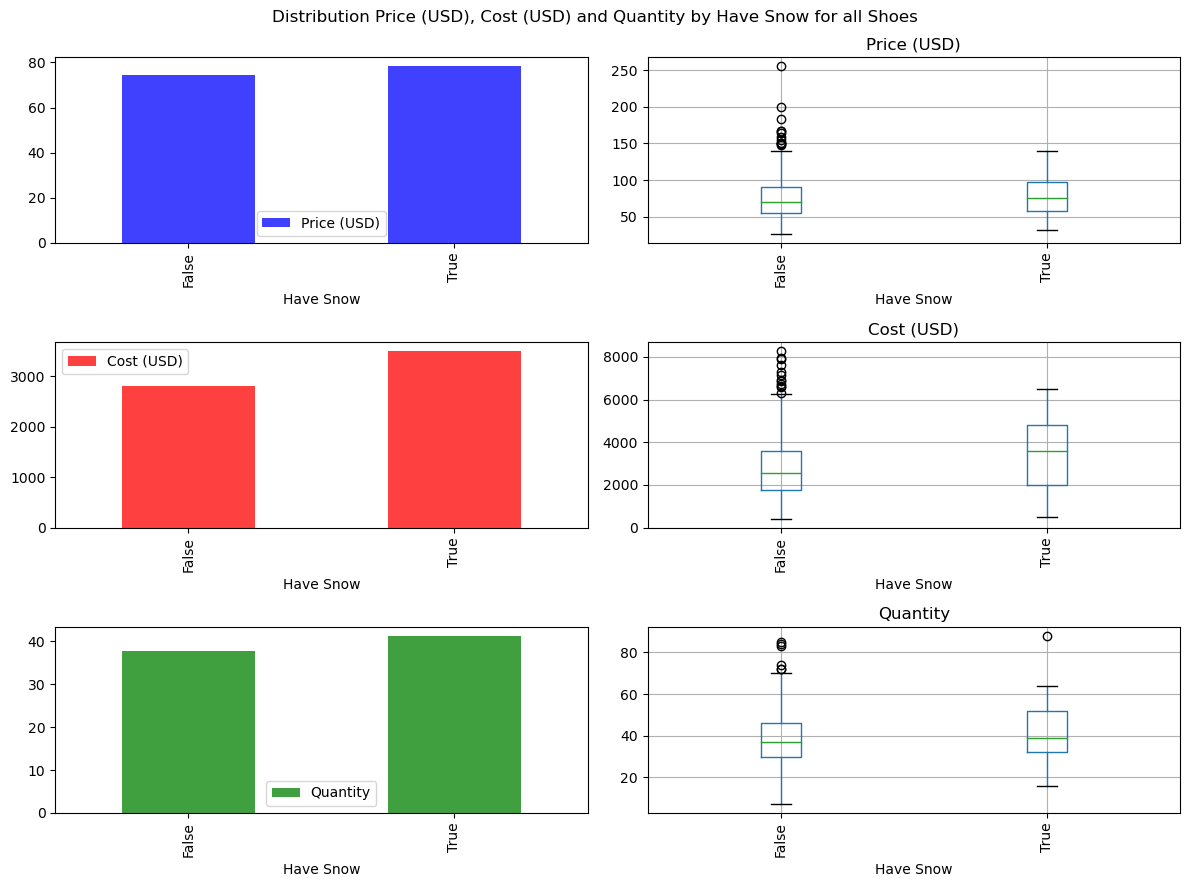

In [173]:
#Check Shoes category distributed by "Have Snow" - comparing days when snow covers the ground vs. other days in a year
df = daily_df[(daily_df["Category"] == "Shoes")]

metrics_distribution_by_attribute(df, attribute_name="Have Snow", title_ext="for all Shoes")

There are statistically significant differences in cost only, that means people buy more expensive shoes when snow covers the ground.

ANOVA test results:
Statistic = 4.943240188608879, p-value = 1.0663747227796732e-07
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Price (USD) by Month.
ANOVA test results:
Statistic = 3.81267039703562, p-value = 1.709682560832863e-05
H0 should be rejected, indicating that there are statistically significant differences in the distribution of Cost (USD) by Month.
ANOVA test results:
Statistic = 0.6966395640881431, p-value = 0.7430840232463347
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of Quantity by Month.


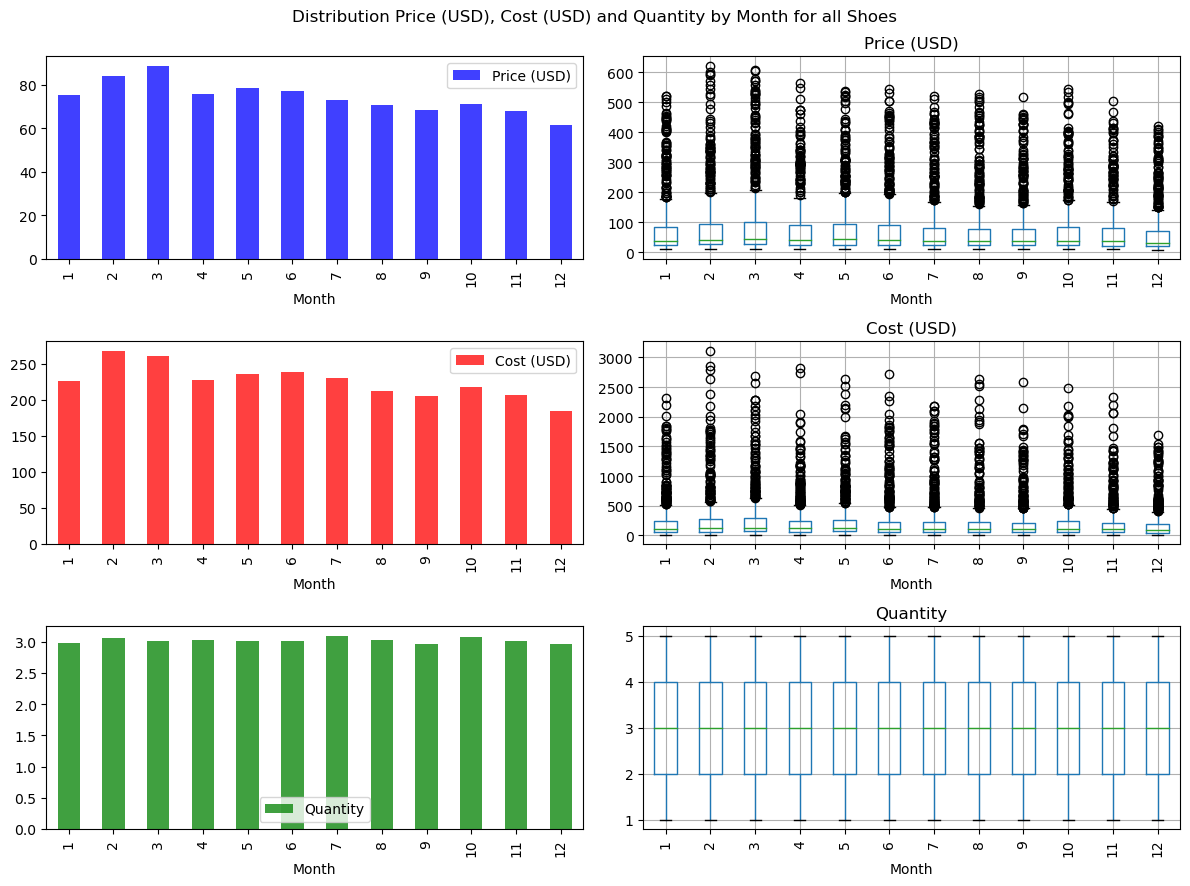

In [174]:
#Check Shoes category distributed by month number
df = full_years_df[(full_years_df["Category"] == "Shoes")]

metrics_distribution_by_attribute(df, attribute_name="Month", title_ext="for all Shoes")

There are statistically significant differences in shoe prices and cost across different months of the year, but not in quantity.

## Average weather conditions over year
Indentify weather patterns for different months

In [175]:
#Examining the months in which weather conditions coincide with increased shoe purchases. 
#This will help in planning advertising campaigns.
#I need to find the average number of days in each month over 2 years that correspond to specific weather conditions.
#Create a new DataFrame grouped by month, year, and weather conditions, and compute the number of days corresponding to them as the count of unique dates in the group.

monthly_weather_df = full_years_df.groupby(["Month", "Year", "Conditions"]).agg(DaysCount=('Invoice Date', 'nunique'))
monthly_weather_df.reset_index(inplace=True)
monthly_weather_df.sort_values(["Month", "Conditions", "Year"]).head()

,Month,Year,Conditions,DaysCount
0,1,2021,Clear,1
1,1,2021,Partially cloudy,8
5,1,2022,Partially cloudy,11
2,1,2021,"Rain, Overcast",1
3,1,2021,"Rain, Partially cloudy",15


In [176]:
#I need to obtain the average number of days per year. We create a pivot table, pivoting the 'Year' column into (in our case) two columns: 2021 and 2022.
#Using 'DaysCount' as values, which represents the number of days.
#Then, I fill all empty values (NaN) with zeros to ensure the mean calculation works correctly later.


#Create a pivot table
monthly_weather_averaged_df = monthly_weather_df.pivot_table(index=['Month', 'Conditions'], columns='Year', values='DaysCount')

#Fill NaN values with 0
monthly_weather_averaged_df = monthly_weather_averaged_df.fillna(0)

monthly_weather_averaged_df

Year                                2021  2022
Month Conditions                              
1     Clear                          1.0   0.0
      Partially cloudy               8.0  11.0
      Rain, Overcast                 1.0   0.0
      Rain, Partially cloudy        15.0   9.0
      Snow, Rain, Partially cloudy   6.0  11.0
2     Clear                          4.0   3.0
      Partially cloudy               8.0   9.0
      Rain                           2.0   1.0
      Rain, Partially cloudy         9.0  15.0
      Snow, Rain, Overcast           1.0   0.0
      Snow, Rain, Partially cloudy   4.0   0.0
3     Clear                          4.0   2.0
      Partially cloudy               5.0   8.0
      Rain                           1.0   0.0
      Rain, Overcast                 0.0   1.0
      Rain, Partially cloudy        21.0  13.0
      Snow, Rain, Partially cloudy   0.0   7.0
4     Clear                          1.0   6.0
      Partially cloudy              12.0  12.0
      Rain, Partially cloudy        17.0  12.0
5     Clear                          6.0   5.0
      Overcast                       0.0   1.0
      Partially cloudy              11.0  17.0
      Rain                           2.0   0.0
      Rain, Partially cloudy        12.0   8.0
6     Clear                          6.0   1.0
      Partially cloudy               6.0  17.0
      Rain                           2.0   0.0
      Rain, Partially cloudy        16.0  12.0
7     Clear                          9.0  13.0
      Partially cloudy              10.0  14.0
      Rain                           2.0   0.0
      Rain, Partially cloudy        10.0   4.0
8     Clear                         10.0   3.0
      Partially cloudy              17.0  18.0
      Rain                           1.0   1.0
      Rain, Partially cloudy         3.0   9.0
9     Clear                          2.0   8.0
      Partially cloudy              14.0   9.0
      Rain, Partially cloudy        14.0  13.0
10    Clear                          3.0   4.0
      Partially cloudy              13.0  13.0
      Rain, Overcast                 0.0   1.0
      Rain, Partially cloudy        15.0  13.0
11    Clear                          3.0   3.0
      Partially cloudy               9.0  14.0
      Rain                           1.0   0.0
      Rain, Partially cloudy        17.0  13.0
12    Clear                          1.0   2.0
      Partially cloudy               6.0   7.0
      Rain, Overcast                 2.0   0.0
      Rain, Partially cloudy        20.0  22.0
      Snow, Rain, Partially cloudy   2.0   0.0

In [177]:
#Calculate the average number of days for each month and condition

monthly_weather_averaged_df['AvgDaysCount'] = monthly_weather_averaged_df.mean(axis=1)

#Reset index to get a flat DataFrame
monthly_weather_averaged_df.reset_index(inplace=True)
monthly_weather_averaged_df = monthly_weather_averaged_df[["Month", "Conditions", "AvgDaysCount"]]

monthly_weather_averaged_df.head()

Year,Month,Conditions,AvgDaysCount
0,1,Clear,0.5
1,1,Partially cloudy,9.5
2,1,"Rain, Overcast",0.5
3,1,"Rain, Partially cloudy",12.0
4,1,"Snow, Rain, Partially cloudy",8.5


In [178]:
pivot_df = monthly_weather_averaged_df.pivot(index='Month', columns='Conditions', values='AvgDaysCount')
pivot_df = pivot_df.fillna(0)
pivot_df.head()

Conditions,Clear,Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy","Snow, Rain, Overcast","Snow, Rain, Partially cloudy"
Month,,,,,,,,
1,0.5,0.0,9.5,0.0,0.5,12.0,0.0,8.5
2,3.5,0.0,8.5,1.5,0.0,12.0,0.5,2.0
3,3.0,0.0,6.5,0.5,0.5,17.0,0.0,3.5
4,3.5,0.0,12.0,0.0,0.0,14.5,0.0,0.0
5,5.5,0.5,14.0,1.0,0.0,10.0,0.0,0.0


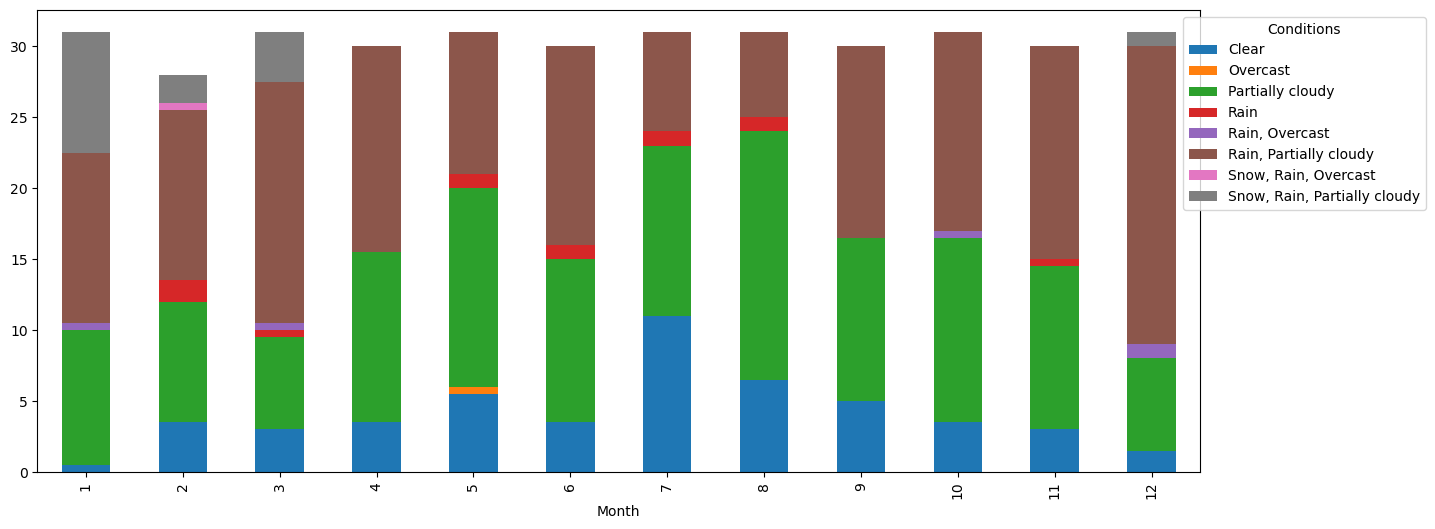

In [179]:
#Plot stacked column chart
pivot_df.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.legend(title='Conditions', bbox_to_anchor=(1.2, 1), loc='upper right')

plt.show()

Snow and rain weather primarily occurs during January, February and March, and a few days in December. So, we can plan marketing campaings for Shoes sells for those months.

## Seasonal changes of average price and total cost and total quantity for different categories
Identifying seasonal trends in sales in different categories

### Seasonal changes in total price, total cost and total quantity for all transactions

Chi-square test results:
Statistic = 5.838354208904301, p-value = 0.8839289487060795
H0 should be accepted, indicating that there are no statistically significant differences in the observed distribution of Price (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 106184.06710746924, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Cost (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 2765.6673750754185, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Quantity comparing to the equal distribution.



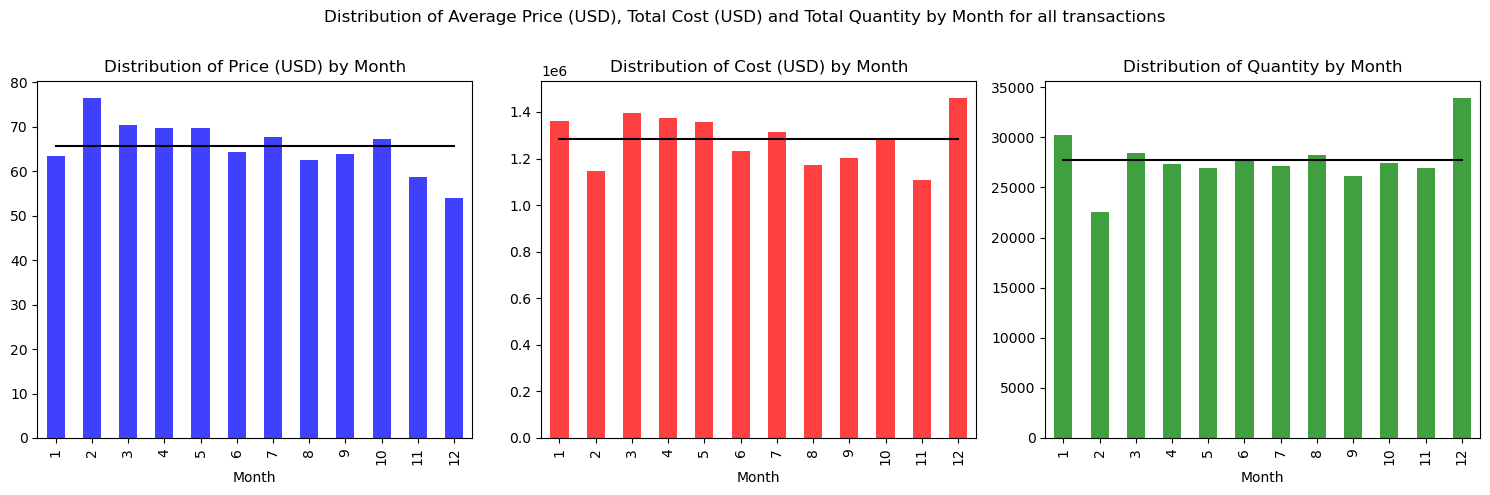

In [180]:
#Comparing the observed distribution of average price, total cost and total quantity by month with the equal distribution for all transactions
df = full_years_df.groupby("Month").agg({"Price (USD)": "mean", "Cost (USD)": "sum", "Quantity": "sum"})

comparison_w_equal_distribution_for_all_metrics(df, "Month", "for all transactions", fig_height=5)

*Black line* is the equal distribution

*Average Price (USD) by Month*: `pvalue` = 0.884, we should accept H0; therefore, the difference in the price distribution by months is random

*Total Cost (USD) by Month*: `pvalue` = 0, we should reject H0; therefore, the difference in the cost distribution by months is not random. **March, April and December** show higher than average total costs, while **February and November** show lower than average costs.

*Total Quantity by Month*: `pvalue` = 0, we should reject H0; therefore, the difference in the quantity distribution by months is not random. **December** shows higher than average total quanitty, while **February** shows lower the average total quantity.

**December** can be considered as the *sales month*, since it shows higher than average both total cost and total quantity.

### Seasonal changes in total price, total cost and total quantity for the Clothing category

Chi-square test results:
Statistic = 9.060069157508337, p-value = 0.6163475878292539
H0 should be accepted, indicating that there are no statistically significant differences in the observed distribution of Price (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 148985.96671343912, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Cost (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 2341.5674559115905, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Quantity comparing to the equal distribution.



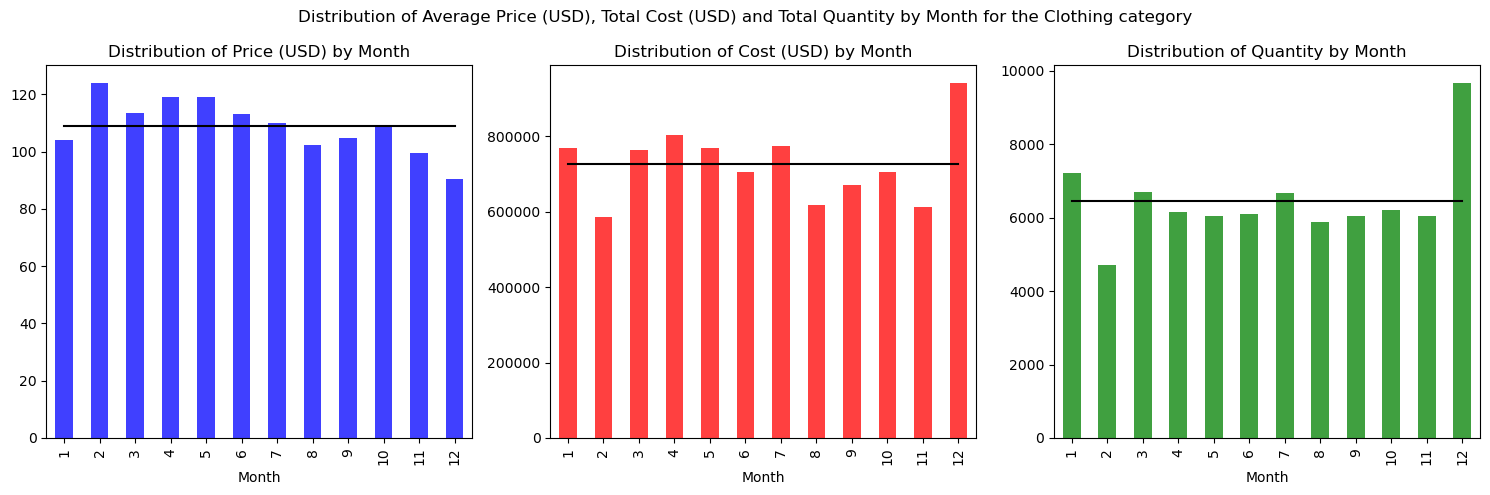

In [181]:
#Comparing the observed distribution of average price, total cost and total quantity by month with the equal distribution for the Clothing category
df = full_years_df[(full_years_df["Category"] == "Clothing")].groupby("Month").agg({"Price (USD)": "mean", "Cost (USD)": "sum", "Quantity": "sum"})

comparison_w_equal_distribution_for_all_metrics(df, "Month", "for the Clothing category", fig_height=5)

*Black line* is the equal distribution

*Average Price (USD) by Month*: `pvalue` = 0.616, we should accept H0; therefore, the difference in the price distribution by months is random

*Total Cost (USD) by Month*: `pvalue` = 0, we should reject H0; therefore, the difference in the cost distribution by months is not random. **April and December** show higher than average total costs, while **February, August and November** show lower than average costs.

*Total Quantity by Month*: `pvalue` = 0, we should reject H0; therefore, the difference in the quantity distribution by months is not random. **December** shows higher than average total quanitty, while **February** shows lower the average total quantity.

**December** can be considered as the *sales month*, since it shows higher than average both total cost and total quantity.

### Seasonal changes in total price, total cost and total quantity for the Cosmetics category

Chi-square test results:
Statistic = 3.4924382264118203, p-value = 0.9824903791154933
H0 should be accepted, indicating that there are no statistically significant differences in the observed distribution of Price (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 15449.000900403073, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Cost (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 583.0892871261035, p-value = 5.791861565905255e-118
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Quantity comparing to the equal distribution.



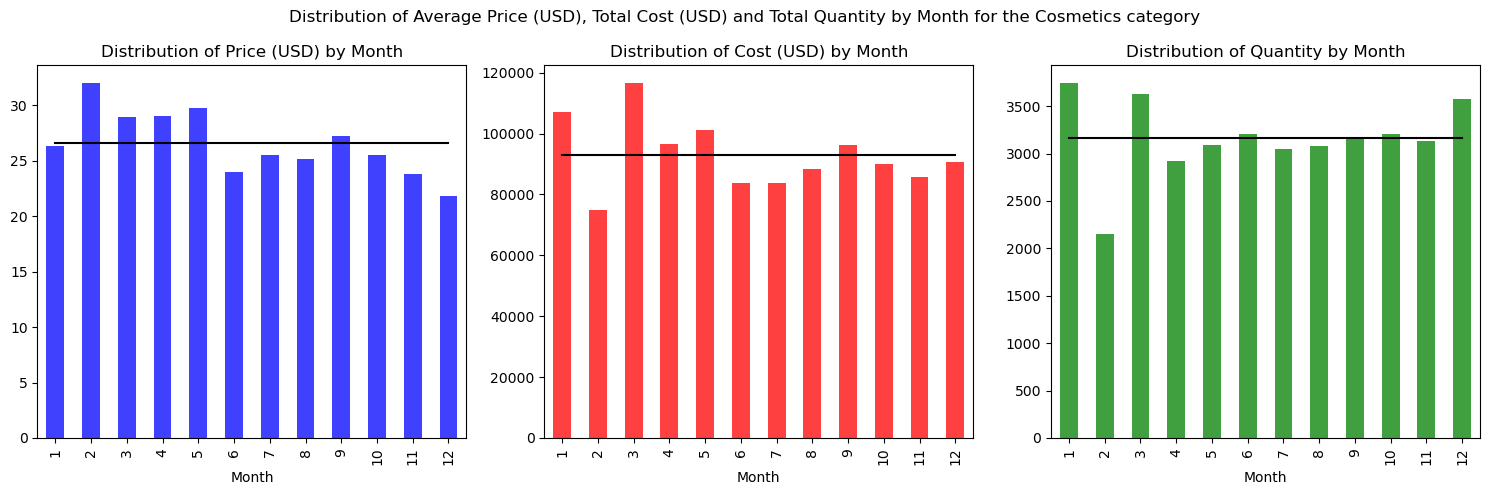

In [182]:
#Comparing the observed distribution of average price, total cost and total quantity by month with the equal distribution for the Cosmetics category
df = full_years_df[(full_years_df["Category"] == "Cosmetics")].groupby("Month").agg({"Price (USD)": "mean", "Cost (USD)": "sum", "Quantity": "sum"})

comparison_w_equal_distribution_for_all_metrics(df, "Month", "for the Cosmetics category", fig_height=5)

*Black line* is the equal distribution

*Average Price (USD) by Month*: `pvalue` = 0.982, we should accept H0; therefore, the difference in the price distribution by months is random

*Total Cost (USD) by Month*: `pvalue` = 0, we should reject H0; therefore, the difference in the cost distribution by months is not random. **January and March** show higher than average total costs, while **Februar, June, July and November** show lower than average costs.

*Total Quantity by Month*: `pvalue` is almost 0, we should reject H0; therefore, the difference in the quantity distribution by months is not random. **January, March and December** shows higher than average total quanitty, while **February** shows lower the average total quantity.

**January and March** can be considered as the *sales months*, since it shows higher than average both total cost and total quantity. It can be explained by a big number of female tourists from Russia in those months, especially for March.

### Seasonal changes in total price, total cost and total quantity for the Food & Beverage category

Chi-square test results:
Statistic = 1.408968745831277, p-value = 0.9997200160192369
H0 should be accepted, indicating that there are no statistically significant differences in the observed distribution of Price (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 12445.071425248647, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Cost (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 1103.6921244909659, p-value = 9.102773918194792e-230
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Quantity comparing to the equal distribution.



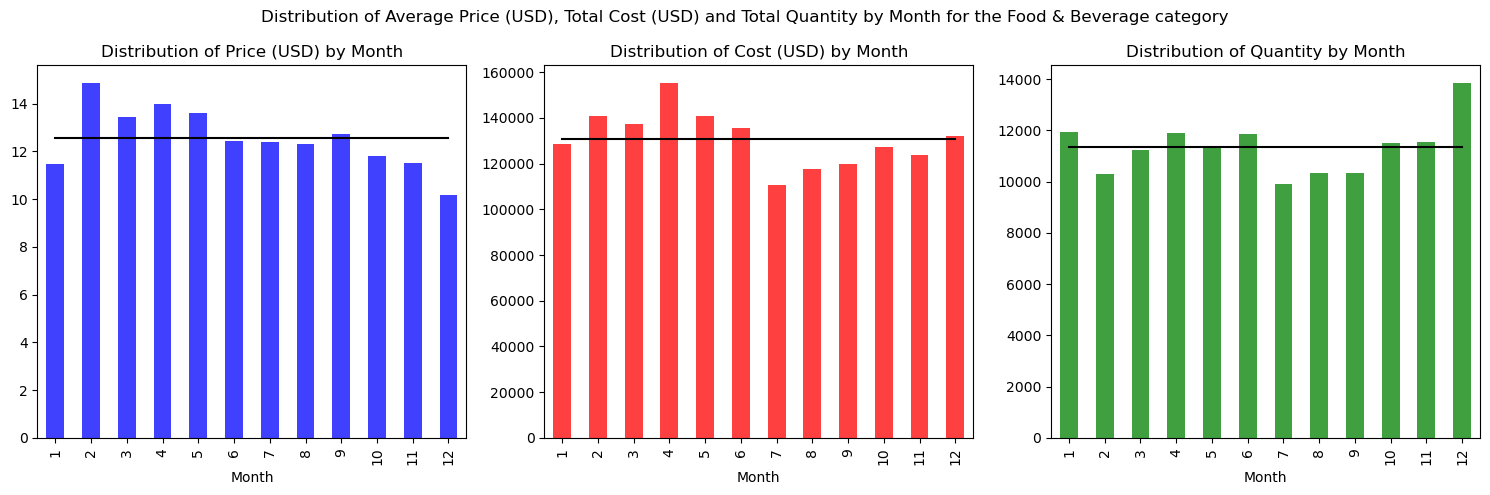

In [183]:
#Comparing the observed distribution of average price, total cost and total quantity by month with the equal distribution for the Food & Beverage category
df = full_years_df[(full_years_df["Category"] == "Food & Beverage")].groupby("Month").agg({"Price (USD)": "mean", "Cost (USD)": "sum", "Quantity": "sum"})

comparison_w_equal_distribution_for_all_metrics(df, "Month", "for the Food & Beverage category", fig_height=5)

*Black line* is the equal distribution

*Average Price (USD) by Month*: `pvalue` = 0.9997, we should accept H0; therefore, the difference in the price distribution by months is random

*Total Cost (USD) by Month*: `pvalue` = 0, we should reject H0; therefore, the difference in the cost distribution by months is not random. **April** show higher than average total costs, while **July and August** show lower than average costs.

*Total Quantity by Month*: `pvalue` is almost 0, we should reject H0; therefore, the difference in the quantity distribution by months is not random. **December** shows higher than average total quanitty, while **February, July, August and September** shows lower the average total quantity.

**April** can be considered as the *most profitable month*, since it shows higher than average total cost for the almost average total quantity.

### Seasonal changes in total price and total quantity in the Souvenir category

Chi-square test results:
Statistic = 0.14287142552823873, p-value = 0.9999999983741396
H0 should be accepted, indicating that there are no statistically significant differences in the observed distribution of Price (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 4283.11843243065, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Cost (USD) comparing to the equal distribution.

Chi-square test results:
Statistic = 2650.551046978409, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution of Quantity comparing to the equal distribution.



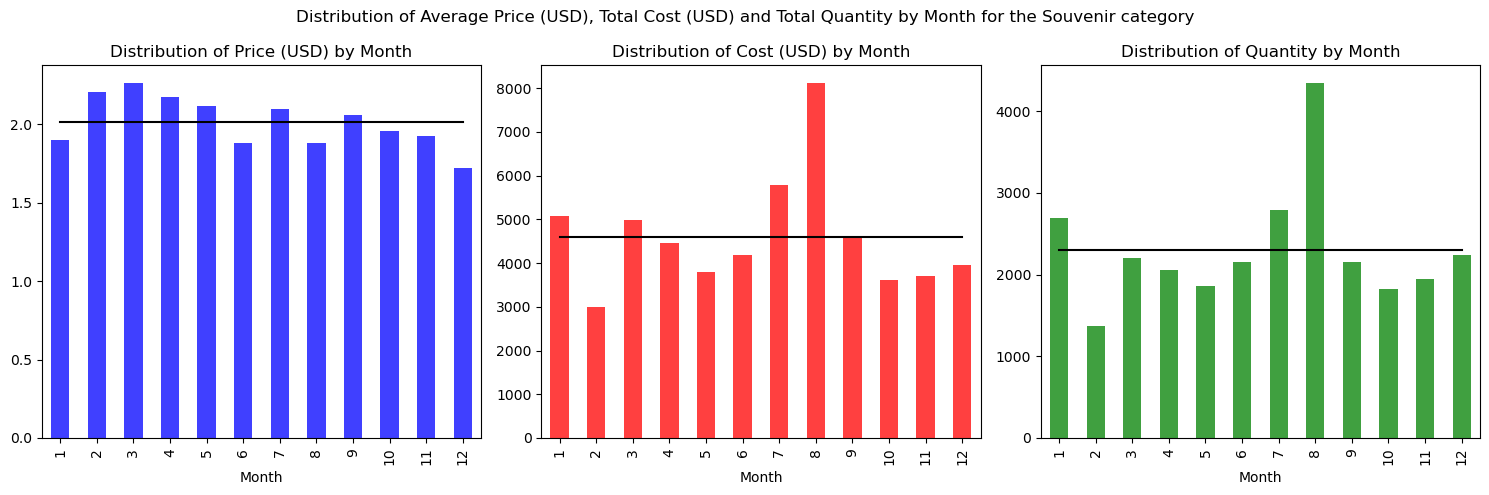

In [184]:
#Comparing the observed distribution of average price, total cost and total quantity by month with the equal distribution for the Souvenir category
df = full_years_df[(full_years_df["Category"] == "Souvenir")].groupby("Month").agg({"Price (USD)": "mean", "Cost (USD)": "sum", "Quantity": "sum"})

comparison_w_equal_distribution_for_all_metrics(df, "Month", "for the Souvenir category", fig_height=5)

*Black line* is the equal distribution

*Average Price (USD) by Month*: `pvalue` is almost 1, we should accept H0; therefore, the difference in the price distribution by months is random

*Total Cost (USD) by Month*: `pvalue` = 0, we should reject H0; therefore, the difference in the cost distribution by months is not random. **July and August** show higher than average total costs, while **February, May, October, November and December** show lower than average costs.

*Total Quantity by Month*: `pvalue` = 0, we should reject H0; therefore, the difference in the quantity distribution by months is not random. **January, July and August** shows higher than average total quanitty, while **February, May, October and November** shows lower the average total quantity.

**August** can be considered as the *sales month*, since it shows higher than average both total cost and total quantity. It can be explained by a touristic season.

## Analyzing seasonal fluctuations in the average price, total cost, and total quantity on a daily level

Correlation between Price (USD) and Day Of Year is -0.2998864944532075
Correlation between Cost (USD) and Day Of Year is 0.013375430713174714
Correlation between Quantity and Day Of Year is 0.28198260524527213


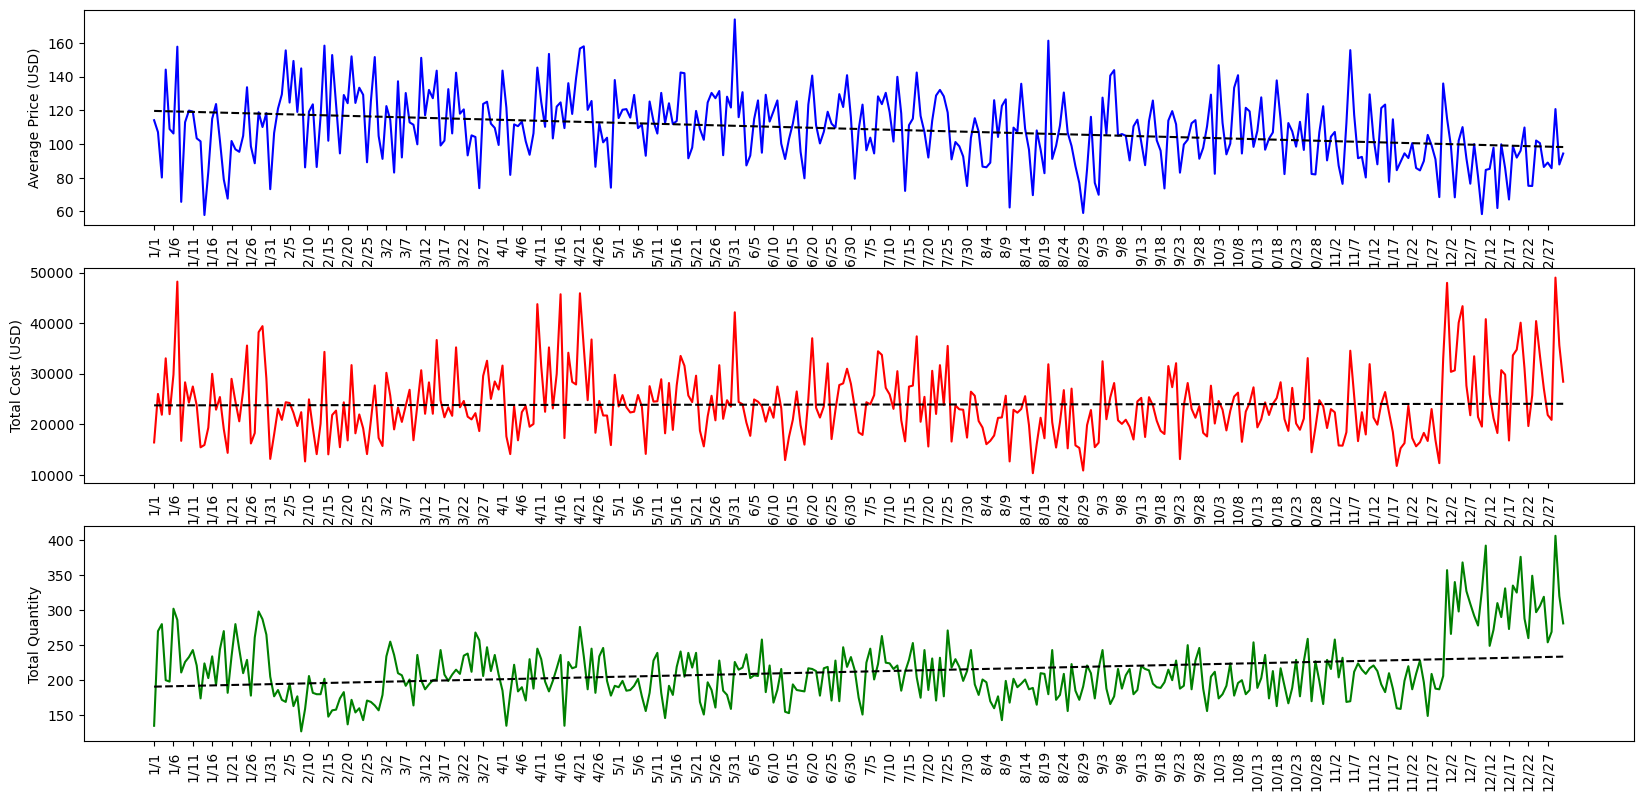

In [185]:
#Analyzing seasonal fluctuations in the average price, total cost, and total quantity of purchases in the Clothing category.
df = full_years_df[(full_years_df["Category"] == "Clothing")]

time_series_plots(df)

There is no correlation for Clothing category, but we can see a few peaks in cost and quantity throughout a year.

Correlation between Price (USD) and Day Of Year is -0.3031697348837629
Correlation between Cost (USD) and Day Of Year is -0.1291854619642871
Correlation between Quantity and Day Of Year is 0.05824991983892308


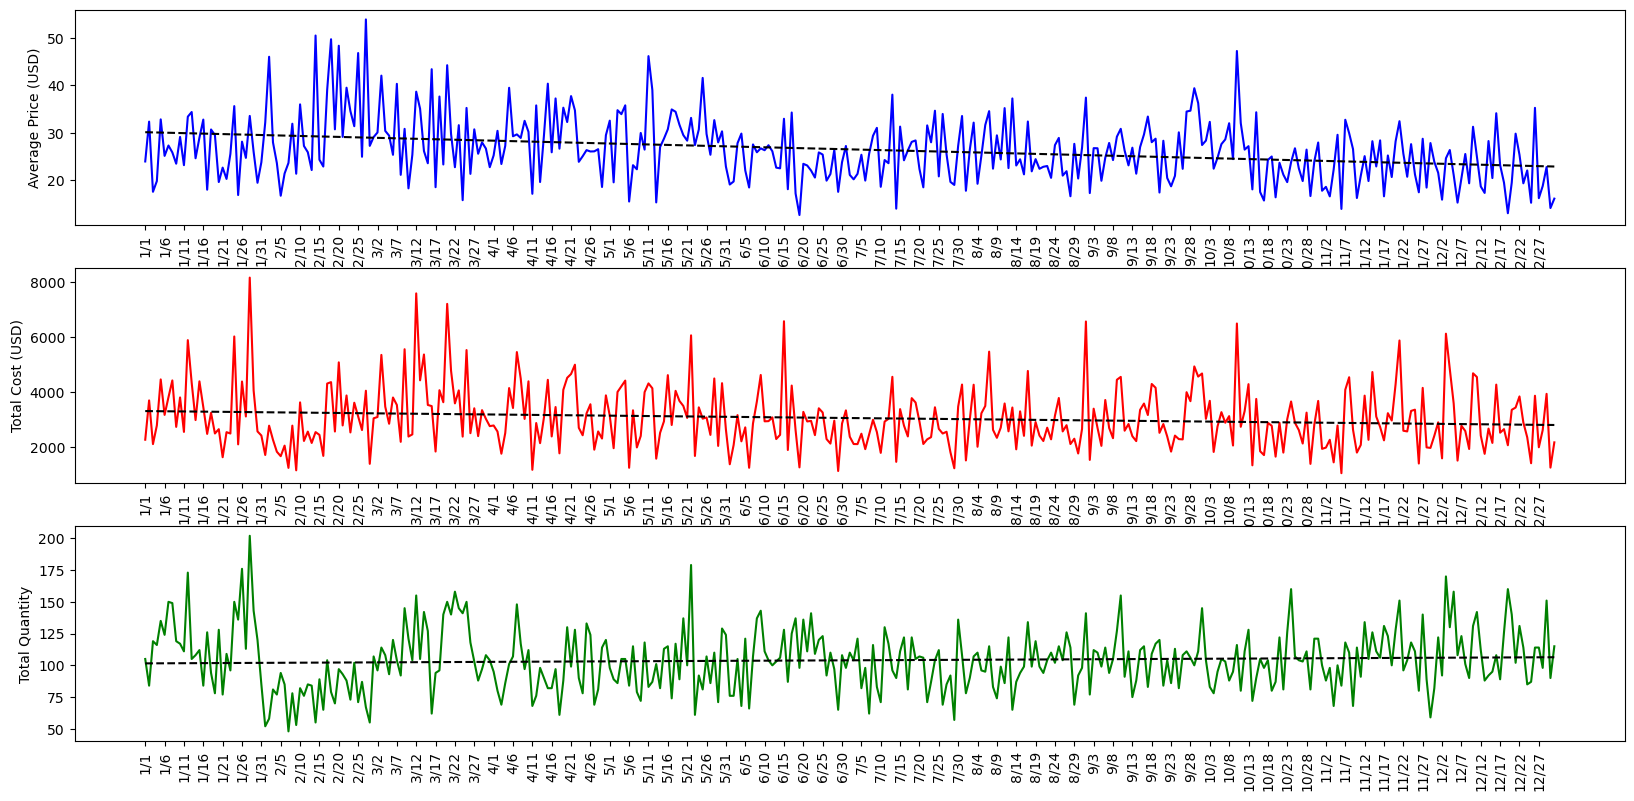

In [186]:
#Analyzing seasonal fluctuations in the average price, total cost, and total quantity of purchases in the Cosmetics category.
df = full_years_df[(full_years_df["Category"] == "Cosmetics")]

time_series_plots(df)

There is a weak correlation for Costmetics category for Price, but we can also see a few peaks in cost and quantity throughout a year.

Correlation between Price (USD) and Day Of Year is -0.3056485901396297
Correlation between Cost (USD) and Day Of Year is -0.20375361449710838
Correlation between Quantity and Day Of Year is 0.06581919231504688


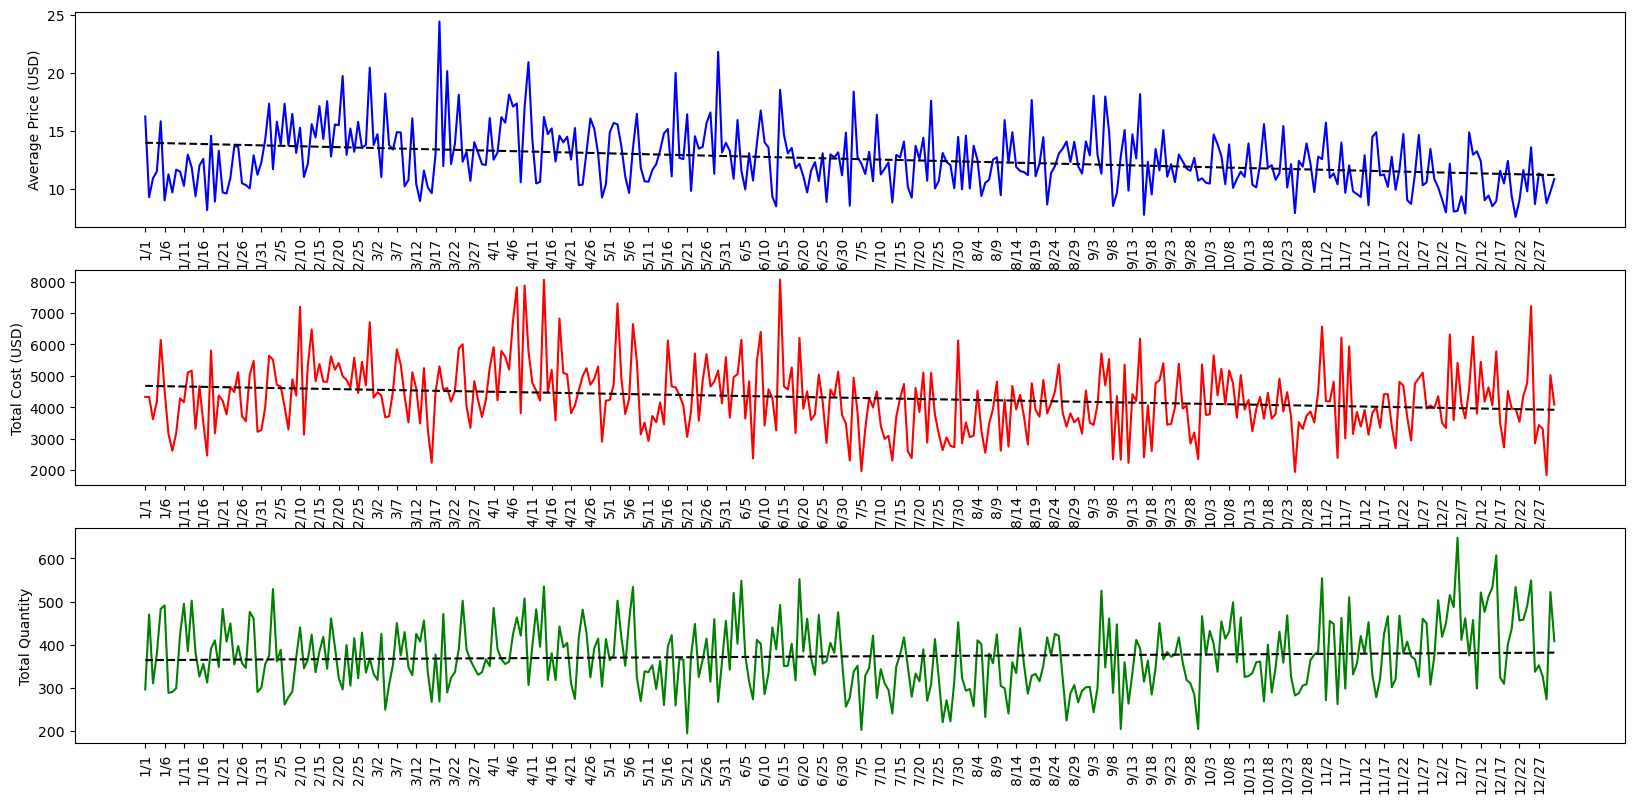

In [187]:
#Analyzing seasonal fluctuations in the average price, total cost, and total quantity of purchases in the Food & Beverage category.
df = full_years_df[(full_years_df["Category"] == "Food & Beverage")]

time_series_plots(df)

There is a weak correlation for Food & Beverage category for Price, but we can also see a few peaks in cost and quantity throughout a year.

Correlation between Price (USD) and Day Of Year is -0.3081110771350778
Correlation between Cost (USD) and Day Of Year is -0.24331559732198565
Correlation between Quantity and Day Of Year is -0.045607200188243185


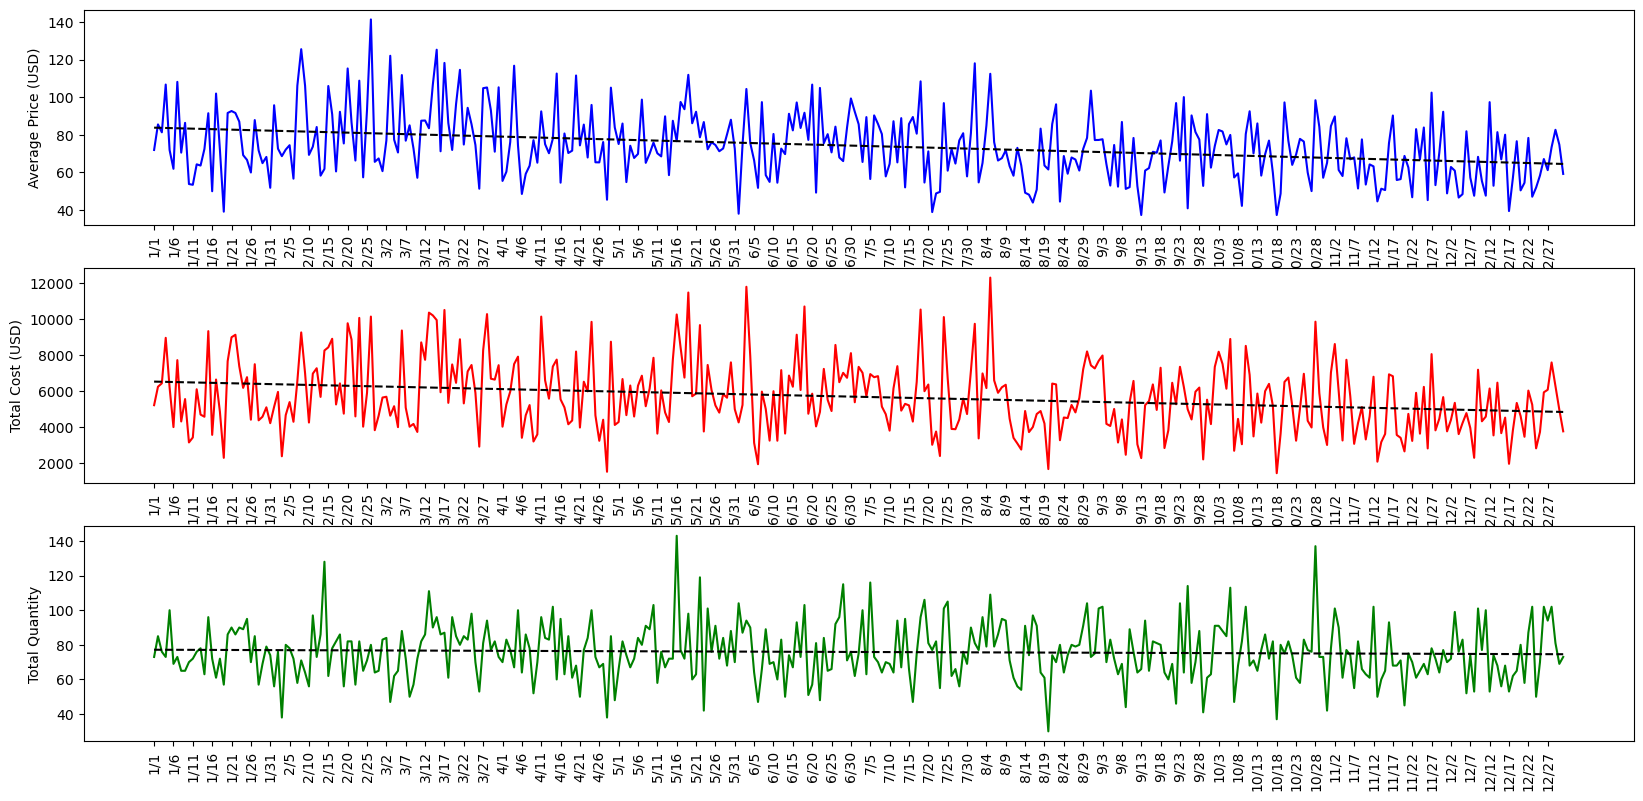

In [188]:
#Analyzing seasonal fluctuations in the average price, total cost, and total quantity of purchases in the Shoes category.
df = full_years_df[(full_years_df["Category"] == "Shoes")]

time_series_plots(df)

There is a weak correlation for Shoes category for Price, but we can also see a few peaks in cost and quantity throughout a year.

Correlation between Price (USD) and Day Of Year is -0.147758113808157
Correlation between Cost (USD) and Day Of Year is -0.017109912596725087
Correlation between Quantity and Day Of Year is 0.05702095707196399


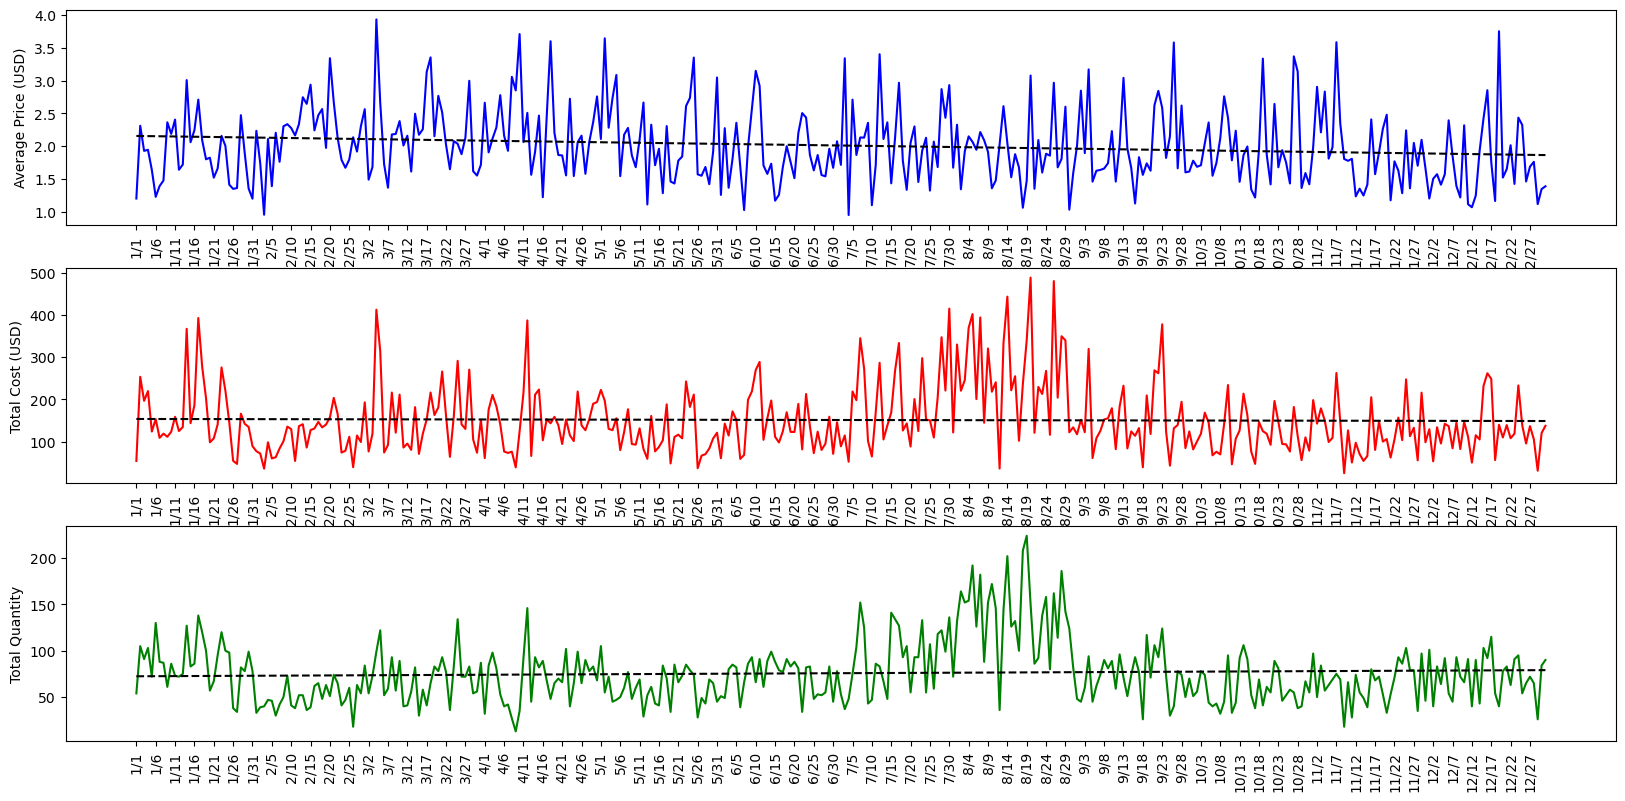

In [189]:
#Analyzing seasonal fluctuations in the average price, total cost, and total quantity of purchases in the Souvenir category.
df = full_years_df[(full_years_df["Category"] == "Souvenir")]

time_series_plots(df)

Despite of the fact that there is no correlation for Souvenir category, we can see peaks for total cost and total quantity in July and especially in August. That can be expained by touristic season.

Correlation between Price (USD) and Day Of Year is -0.34724351453029584
Correlation between Cost (USD) and Day Of Year is -0.17172415405116234
Correlation between Quantity and Day Of Year is 0.08346679769862629


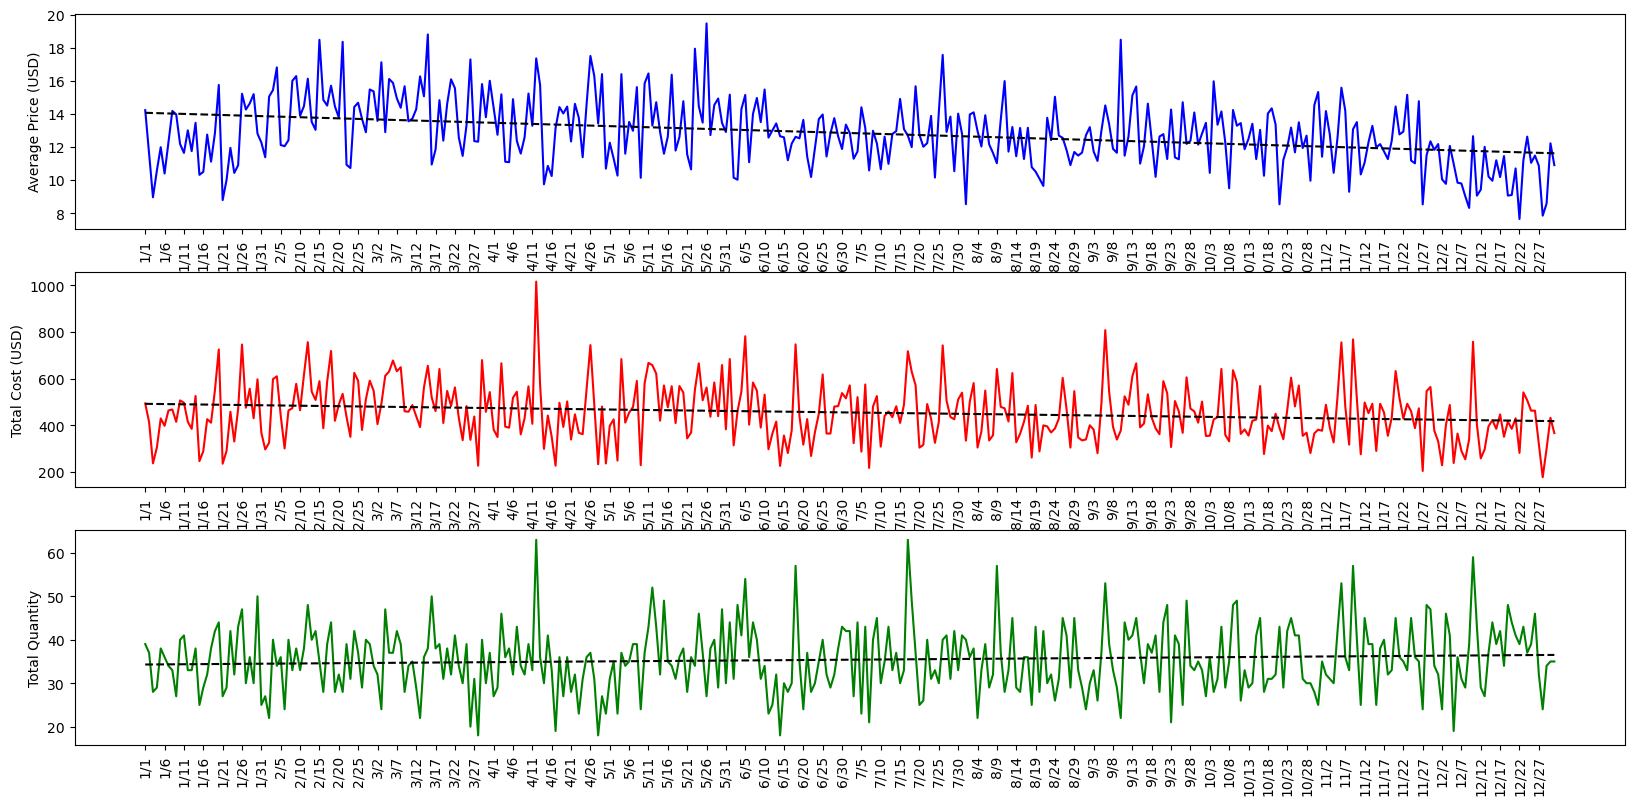

In [190]:
#Analyzing seasonal fluctuations in the average price, total cost, and total quantity of purchases in the Toys category.
df = full_years_df[(full_years_df["Category"] == "Toys")]

time_series_plots(df)

There is a weak correlation for Toys category for Price, but we can also see a few peaks in cost and quantity throughout a year.